# Training a spiking network to deploy to Dynap-SE2

This notebook shows how to train a spiking model using `DynapSim` and train on a simple task.
The objective is to train a DynapSim network to classify two synthetically generated frozen noise sample, and to deploy the application to a Dynap-SE2 chip.
The experiment uses most of the features provided by the DynapSim toolchain by designing an SNN with DynapSim layers, simulating and optimizing the parameters and obtaining a device configuration.

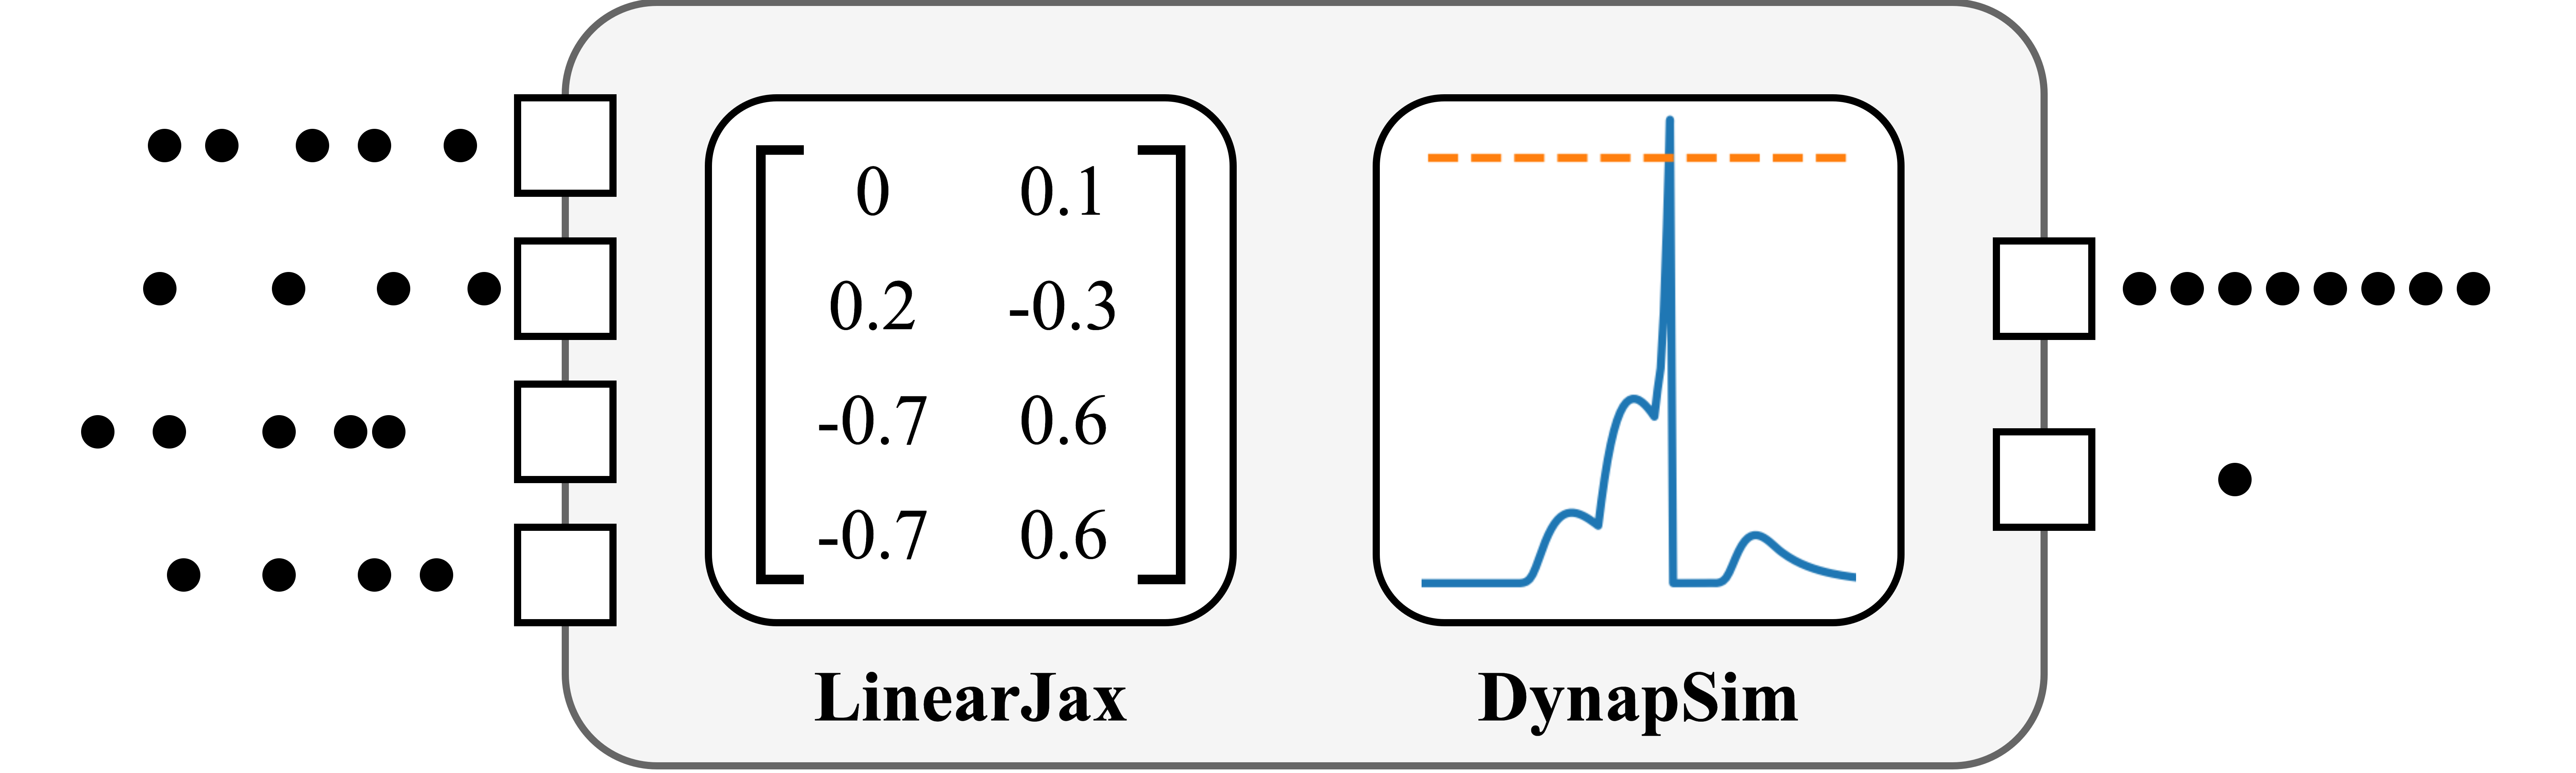

In [1]:
from IPython.display import Image
Image("images/frozen_noise.png")


This toy task is named as "Frozen Noise Classification".
This experiment aims to train a Dynapsim network to classify two randomly generated frozen noise patterns.
The network includes 2 analog neurons with recurrent connections and 60 external input connections.
The target behavior is when the network receive the first frozen noise, the first neuron will fire at a significantly higher rate.
Accordingly, receiving the second frozen noise, the second neuron should fire at a significantly higher rate.


## Imports

In [2]:
# Utils
import numpy as np
from tqdm import tqdm

# Rockpool Imports
from rockpool.timeseries import TSEvent
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential

## Jax Imports
from jax import random as rand
from jax import numpy as jnp

from rockpool.devices.dynapse import DynapSim, dynamic_mismatch_prototype
from rockpool.transform.mismatch import mismatch_generator

from utils import FrozenNoiseDataset, plot_Ix

# - Plotting and config
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [4.8, 2.4]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.size"] = 10

/Users/ugurcancakal/rockpool/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


## Tutorial Utils

In [3]:
%psource FrozenNoiseDataset

class FrozenNoiseDataset:
    """
    FrozenNoise is a synthetic dataset implementation for testing DynapSim training pipeline.
    It generates possion spike train rasters

    :param n_samples: number of samples included in the dataset
    :type n_samples: int
    :param n_channels: number of spiking channels (input neurons), defaults to 60
    :type n_channels: int, optional
    :param duration: the duration of each synthetic recording, defaults to 500e-3
    :type duration: float, optional
    :param dt: The discrete time resolution of the recording, defaults to 1e-3, defaults to 1e-3
    :type dt: float, optional
    :param rate: mean firing rate in Hz (applies to all channels), defaults to 50
    :type rate: float, optional
    :param seed: random number generator seed, defaults to 2022
    :type seed: Optional[float], optional
    """

    def __init__(
        self,
        n_samples: int,
        n_channels: int = 60,
        duration: float = 500e-3,
        dt: float = 1e-3,

## Step 1 : Synthetic Dataset Generation

The frozen noise patterns have a mean frequency of 50 Hz in 500 ms duration.
Each sample has 60 channels, meaning each can be regarded as a composition of 60 discrete poisson time series.
The discrete time-step length is 1 ms.
The `train_data` samples will be used to train the network.

The `test_data` samples will be used to provide a negative test.
Test dataset includes the same mean frequency, the same duration samples. 
The trained network does expose a clear decision for them, because the network is not trained for this.

In [4]:
train_data = FrozenNoiseDataset(2)
test_data = FrozenNoiseDataset(1000, seed=2023)

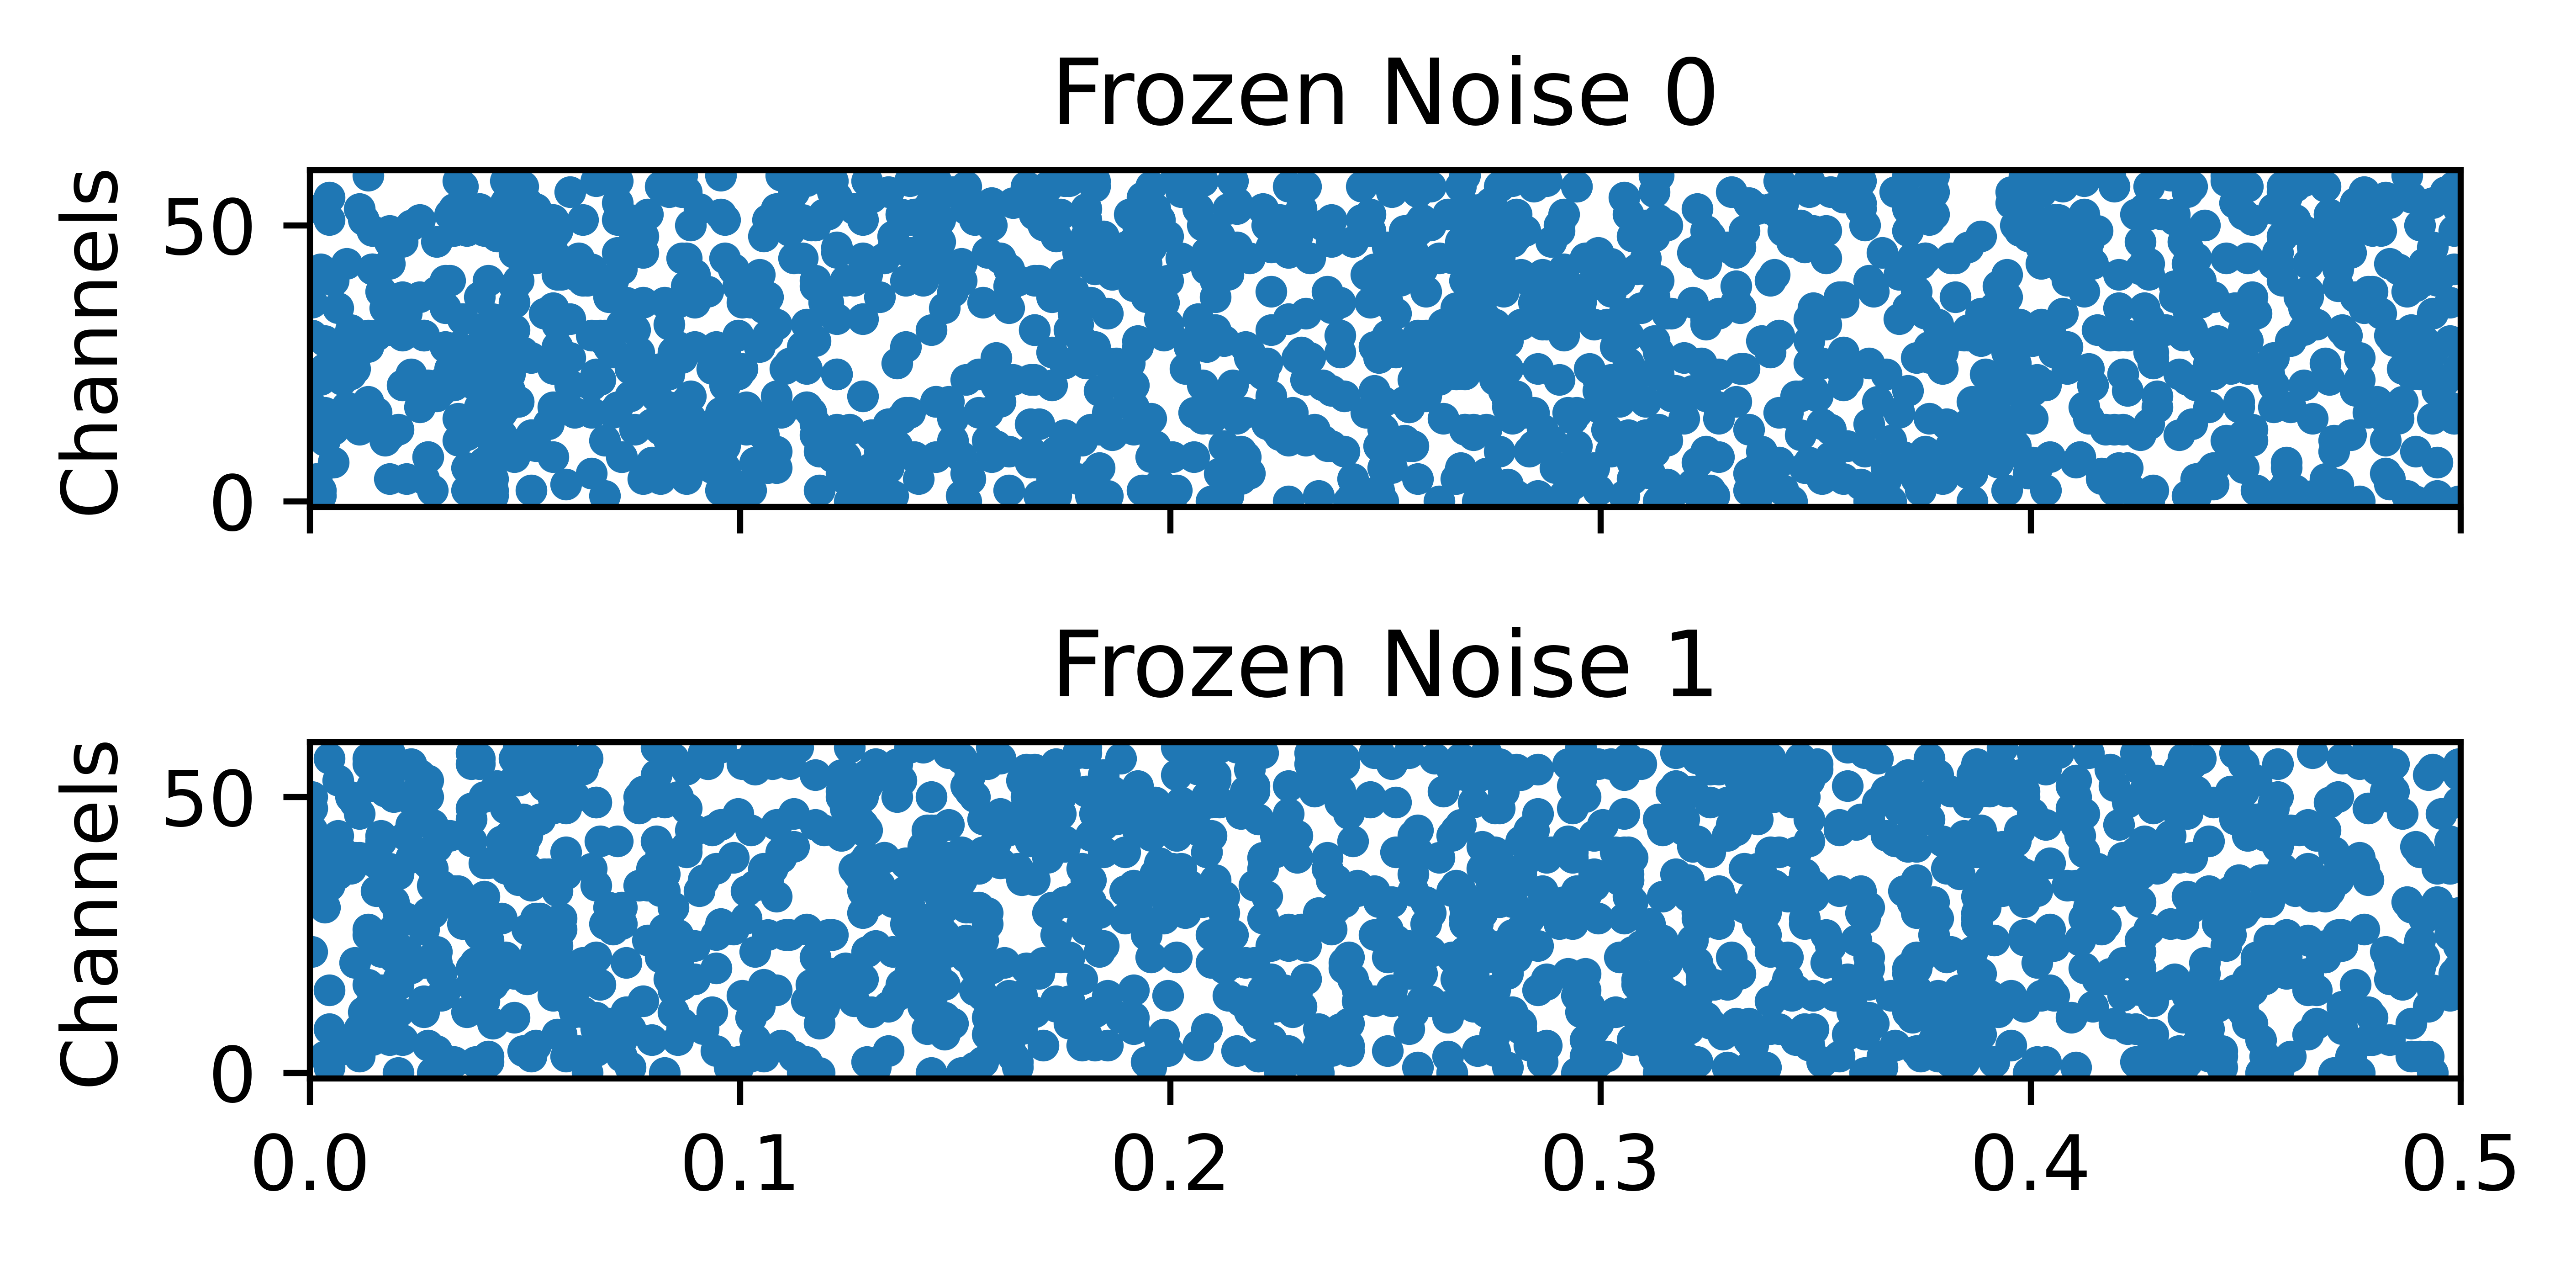

In [5]:
train_data.plot_samples()

## Step 2 : Build a network in Rockpool

Similar to quick start tutorial, we will build the network by defining the input and output dimensions.
Different from the quick start, we will use the mismatch simulation. 

Being a mixed signal chip, Dynap-SE2 suffers from the analog device mismatch issue that all those analog processors face, too. 

Check references:

* Büchel, J., Zendrikov, D., Solinas, S. et al. Supervised training of spiking neural networks for robust deployment on mixed-signal neuromorphic processors. Sci Rep 11, 23376 (2021).

* Zendrikov, D., Solinas, S., & Indiveri, G. (2022). Brain-inspired methods for achieving robust computation in heterogeneous mixed-signal neuromorphic processing systems. bioRxiv.

Device mismatch simulation deviates the parameters with a gaussian distribution, pinning the initial values as the mean values.
In this way, the simulator can expose the reality better.

In [6]:
Nin = train_data.n_in
Nrec = train_data.n_out
dt = 1e-3

In [7]:
net = Sequential(
    LinearJax(shape=(Nin, Nrec), has_bias=False),
    DynapSim((Nrec, Nrec), has_rec=True, percent_mismatch=0.05, dt=dt),
)
net

JaxSequential  with shape (60, 2) {
    LinearJax '0_LinearJax' with shape (60, 2)
    DynapSim '1_DynapSim' with shape (2, 2)
}

### Step 2.1 : The initial Results of Frozen Noise 0

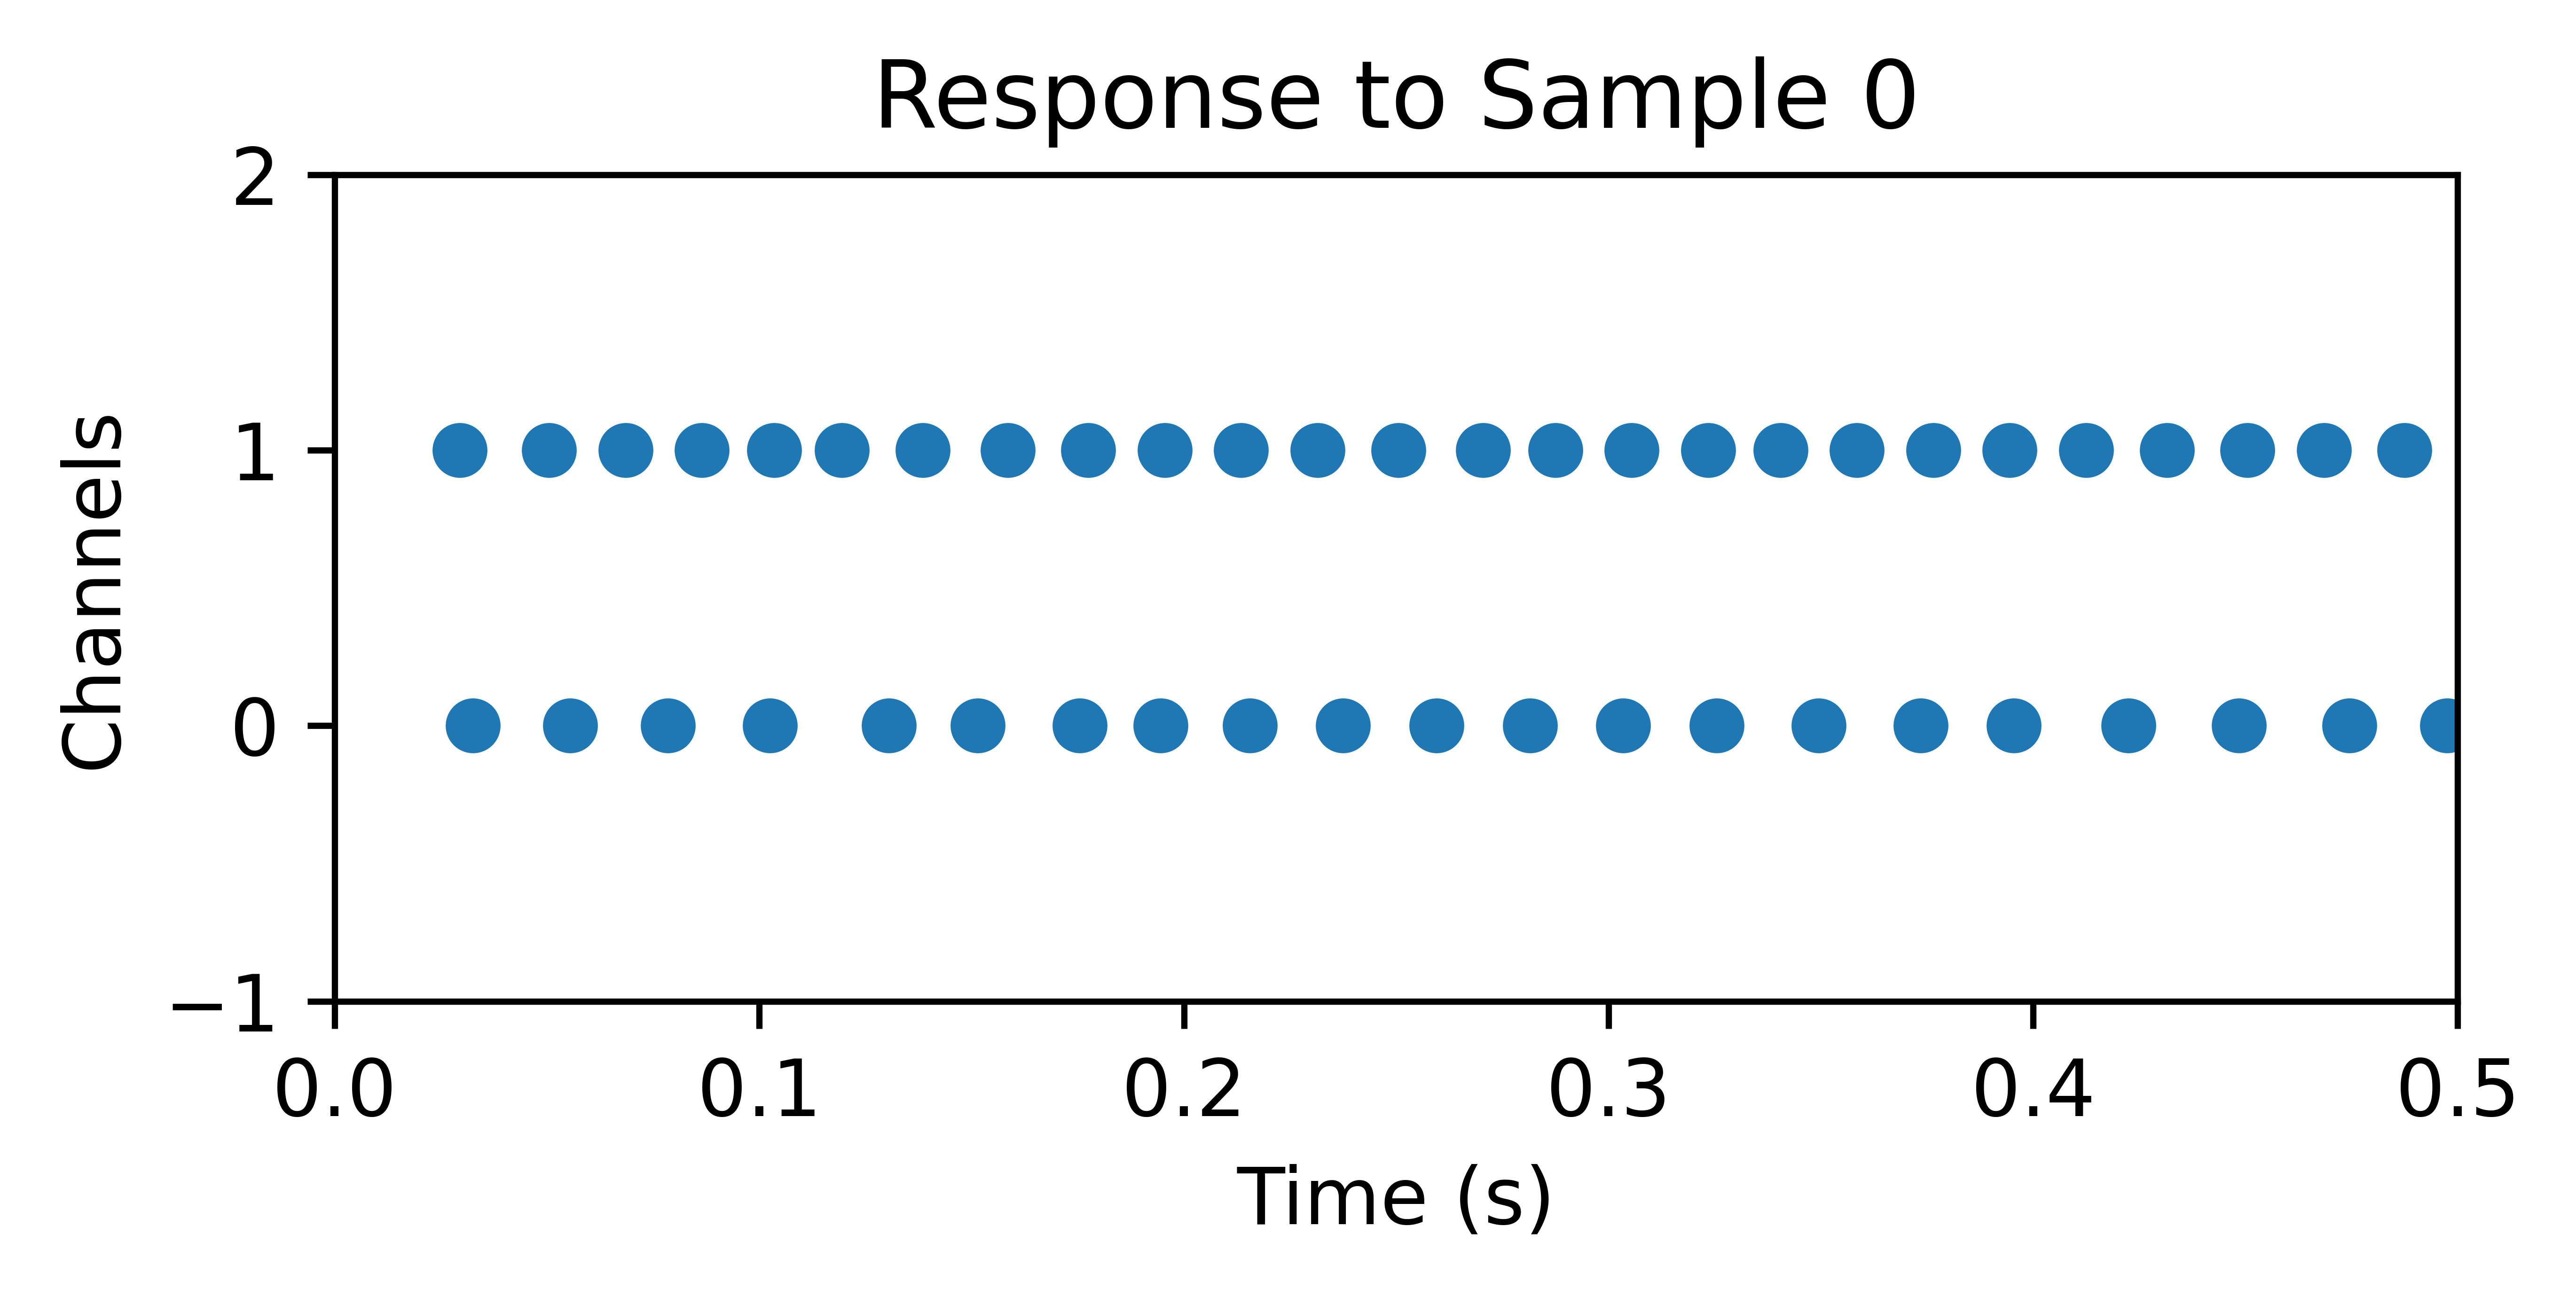

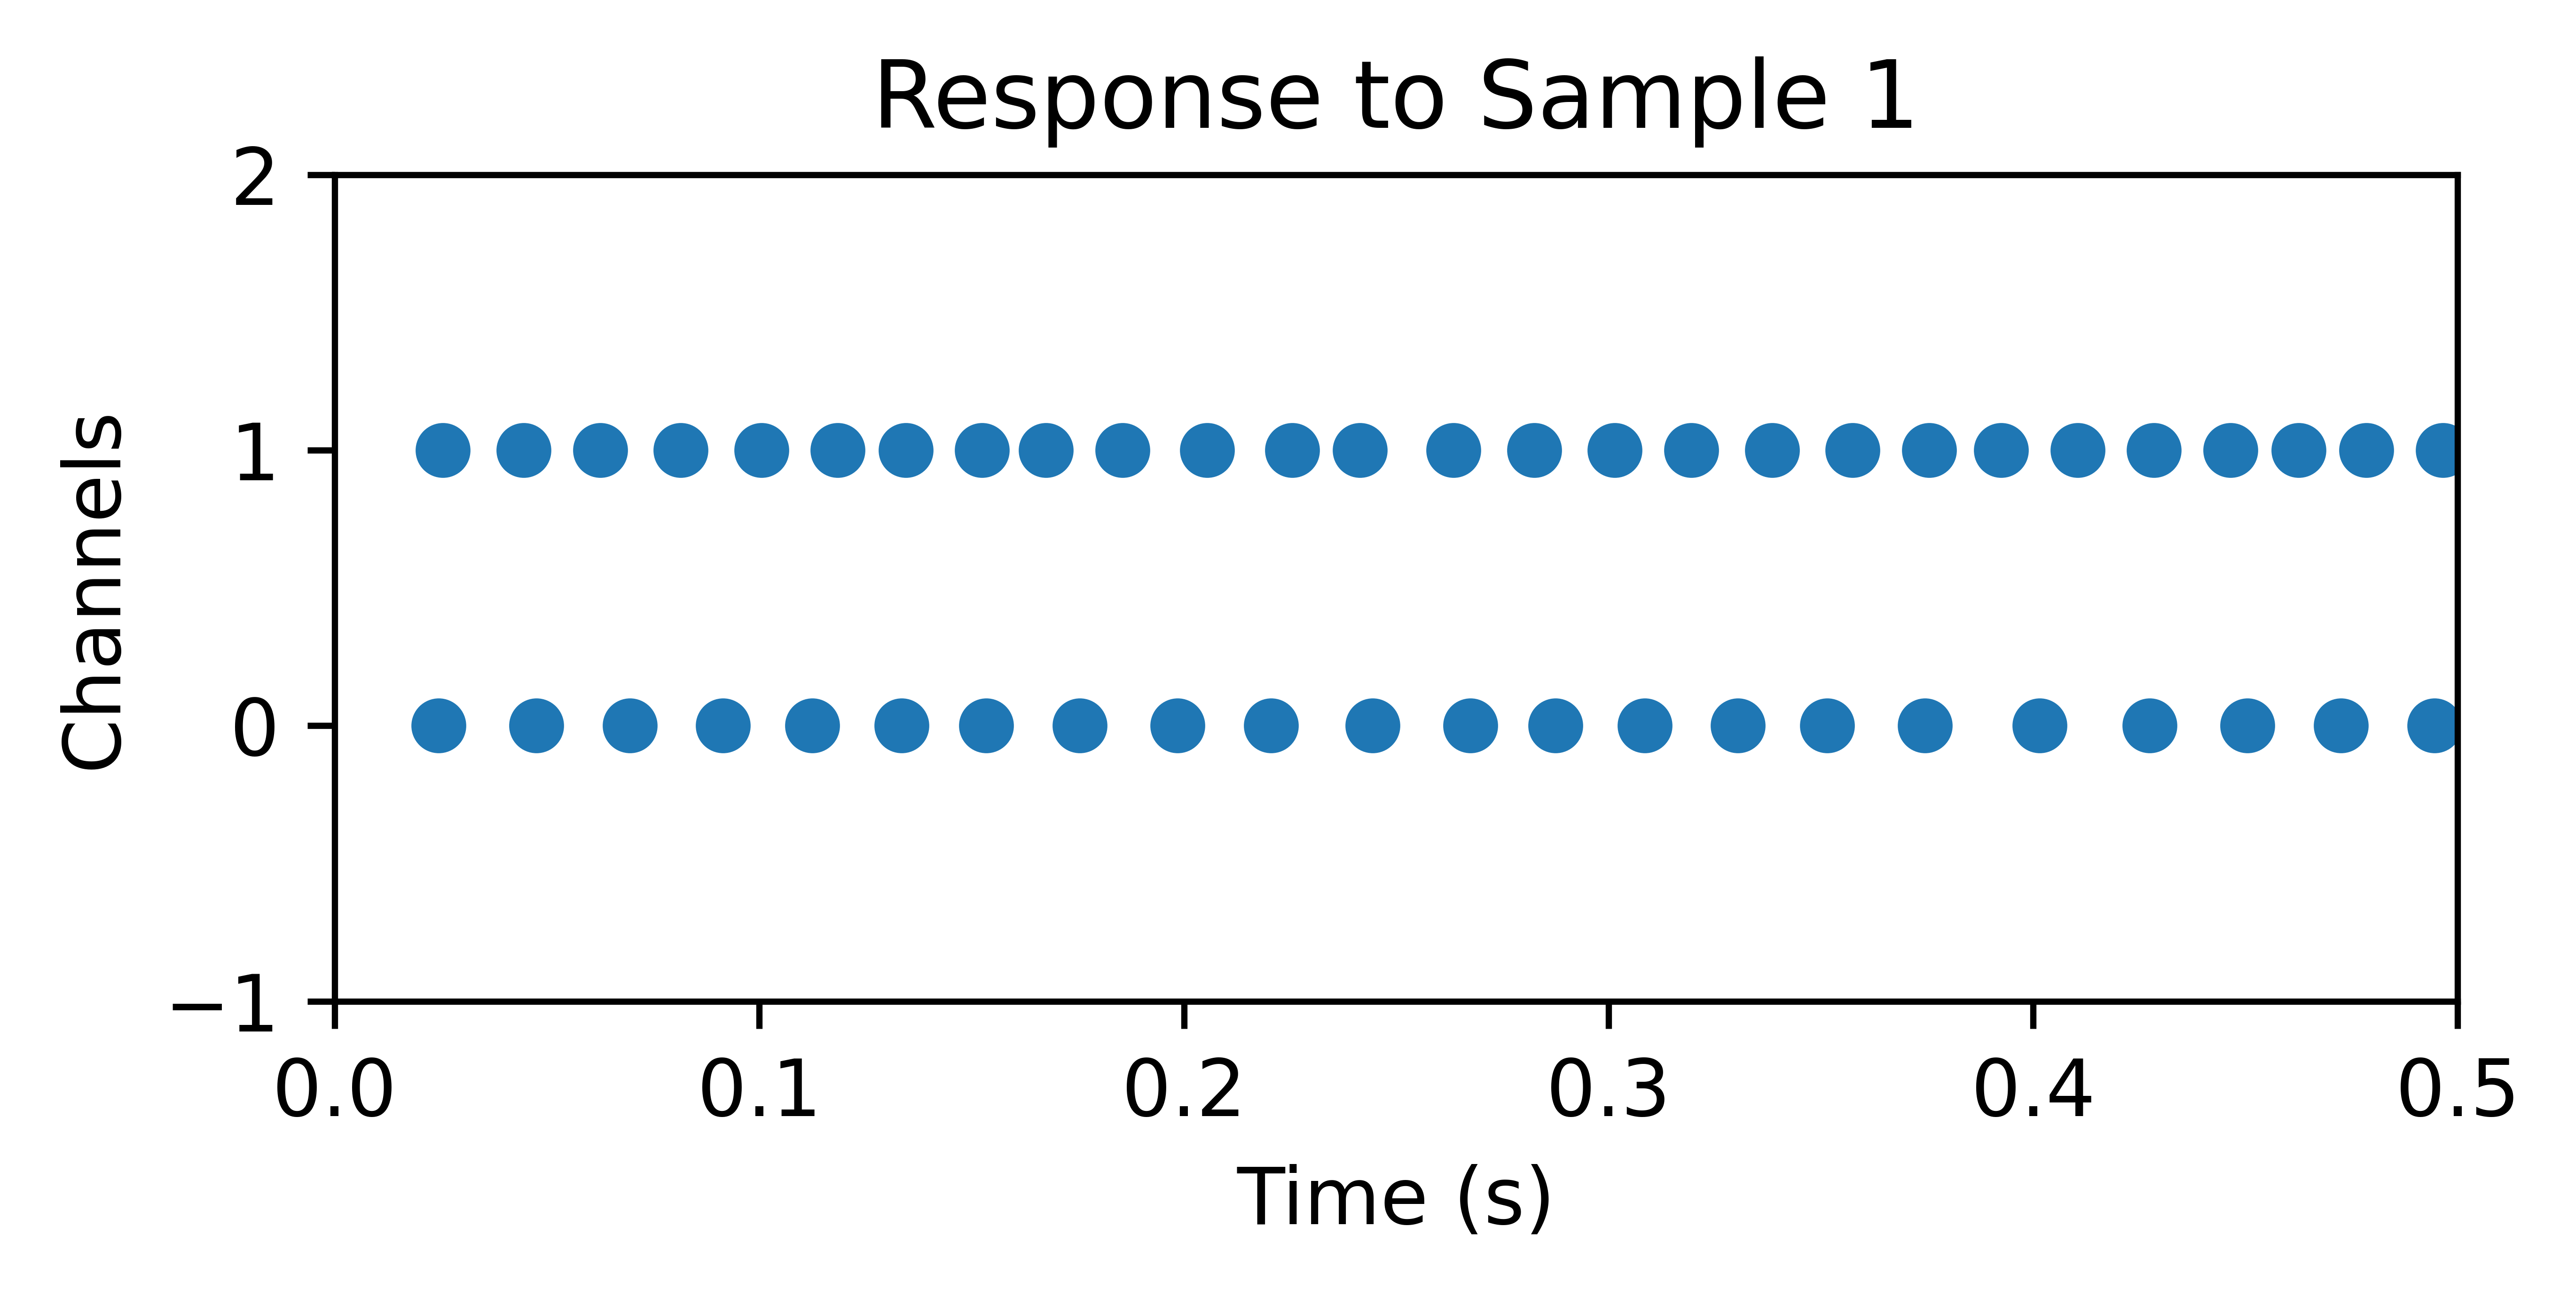

In [8]:
FrozenNoiseDataset.plot_model_response(net, train_data, dt)

## Step 3 : Response Analysis

## Step 4 : Optimization

In [9]:
# - Jax imports
import jax
from jax.example_libraries.optimizers import adam
from rockpool.training import jax_loss as jl


### Step 4. Optimizer

In [10]:
# - Initialise optimiser
learning_rate = 1e-2

init_fun, update_fun, get_params = adam(learning_rate)
opt_state = init_fun(net.parameters())
update_fun = jax.jit(update_fun)

### Step 4. Loss Function

In [11]:
# - Loss function
@jax.jit
@jax.value_and_grad
def loss_vgf(params, net, input, target):
    net = net.set_attributes(params)
    net = net.reset_state()
    output, _, _ = net(input)
    return jl.mse(output, target)

### Step 4. Mismatch Generator (Optional)

In [12]:
percent_deviation = 0.30
sigma_rule = 3.0
rng_key = jnp.array([2021, 2022], dtype=jnp.uint32)

mismatch_prototype = dynamic_mismatch_prototype(net)
regenerate_mismatch = mismatch_generator(mismatch_prototype, percent_deviation, sigma_rule)
regenerate_mismatch = jax.jit(regenerate_mismatch)

In [13]:
batch_input, batch_target  = train_data[:,:,:]

In [14]:
# - Configure learning
num_epochs = int(3e5)
apply_mismatch = True

loss_t = []
# - Training loop
t = tqdm(range(num_epochs), desc='Training', unit='Epoch', total=num_epochs)
    
for epoch in t:
    # - Get parameters
    opt_parameters = get_params(opt_state)

    # - Regenerate mismatch
    if apply_mismatch and epoch%100 == 0:
        rng_key, _ = rand.split(rng_key)
        new_params = regenerate_mismatch(net, rng_key=rng_key)
        net = net.set_attributes(new_params)

    # - Compute loss and gradient
    l, g = loss_vgf(opt_parameters, net, batch_input, batch_target)
    loss_t.append(l.item())
    t.set_postfix({'loss': l.item()}, refresh = False)

    # - Update optimiser
    opt_state = update_fun(epoch, g, opt_state)

Training: 100%|██████████| 300000/300000 [02:03<00:00, 2423.31Epoch/s, loss=0.455]


## Plot Loss

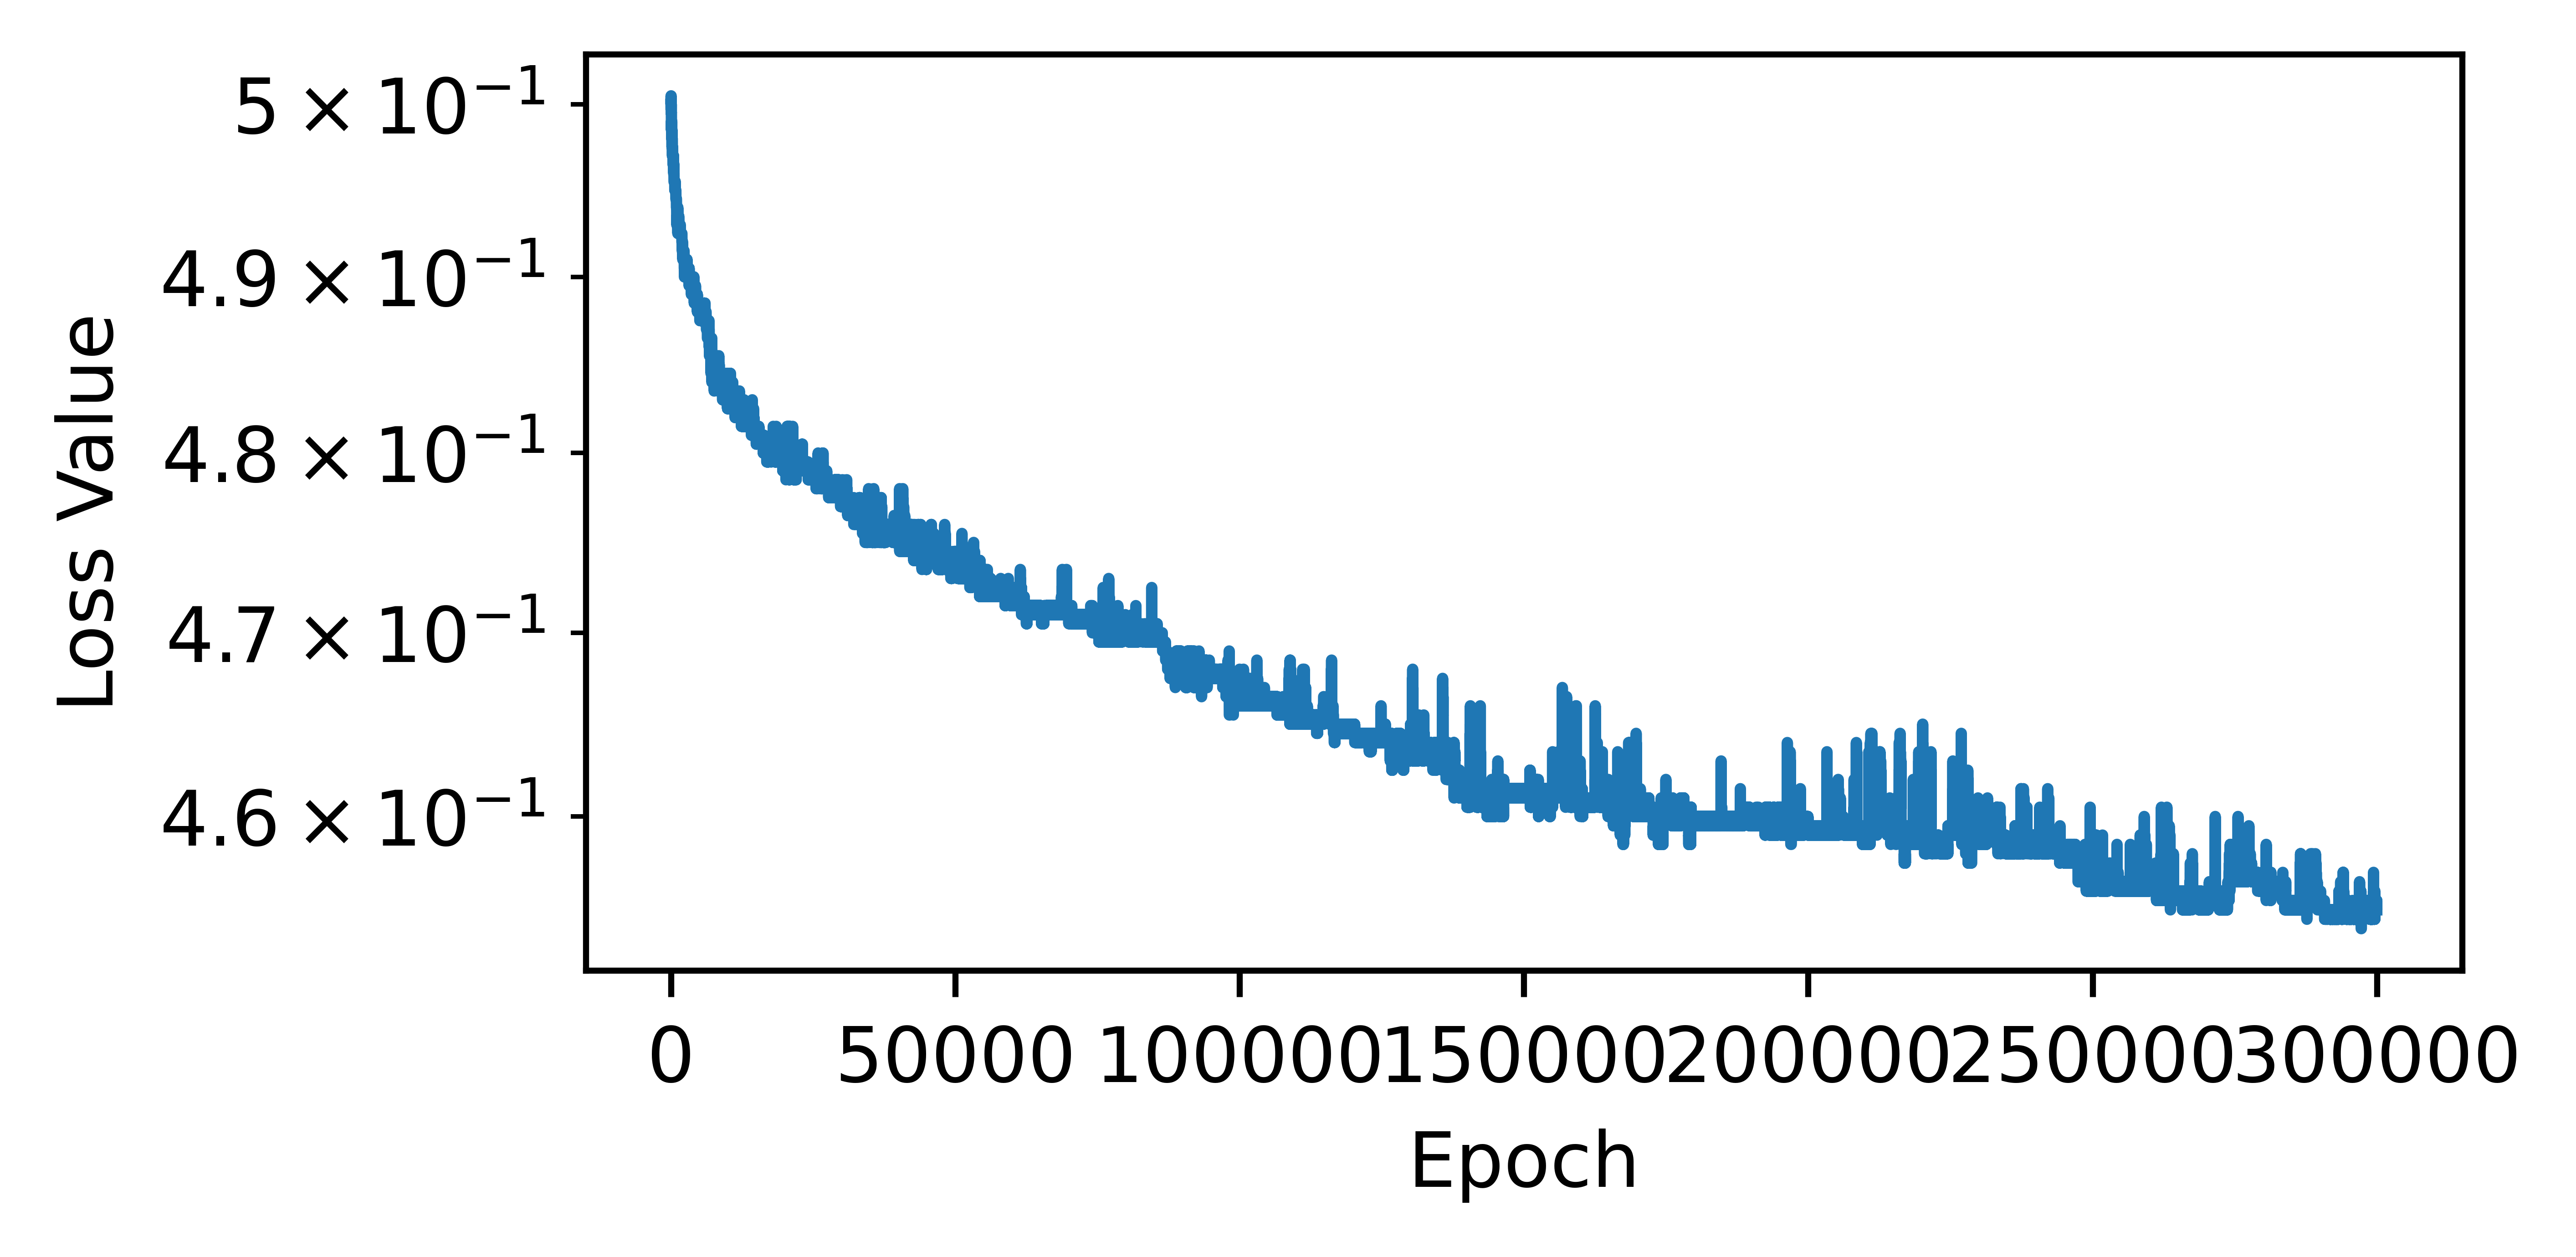

In [15]:
plt.semilogy(loss_t)
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.tight_layout()

In [16]:
net_optimized = net.set_attributes(get_params(opt_state))

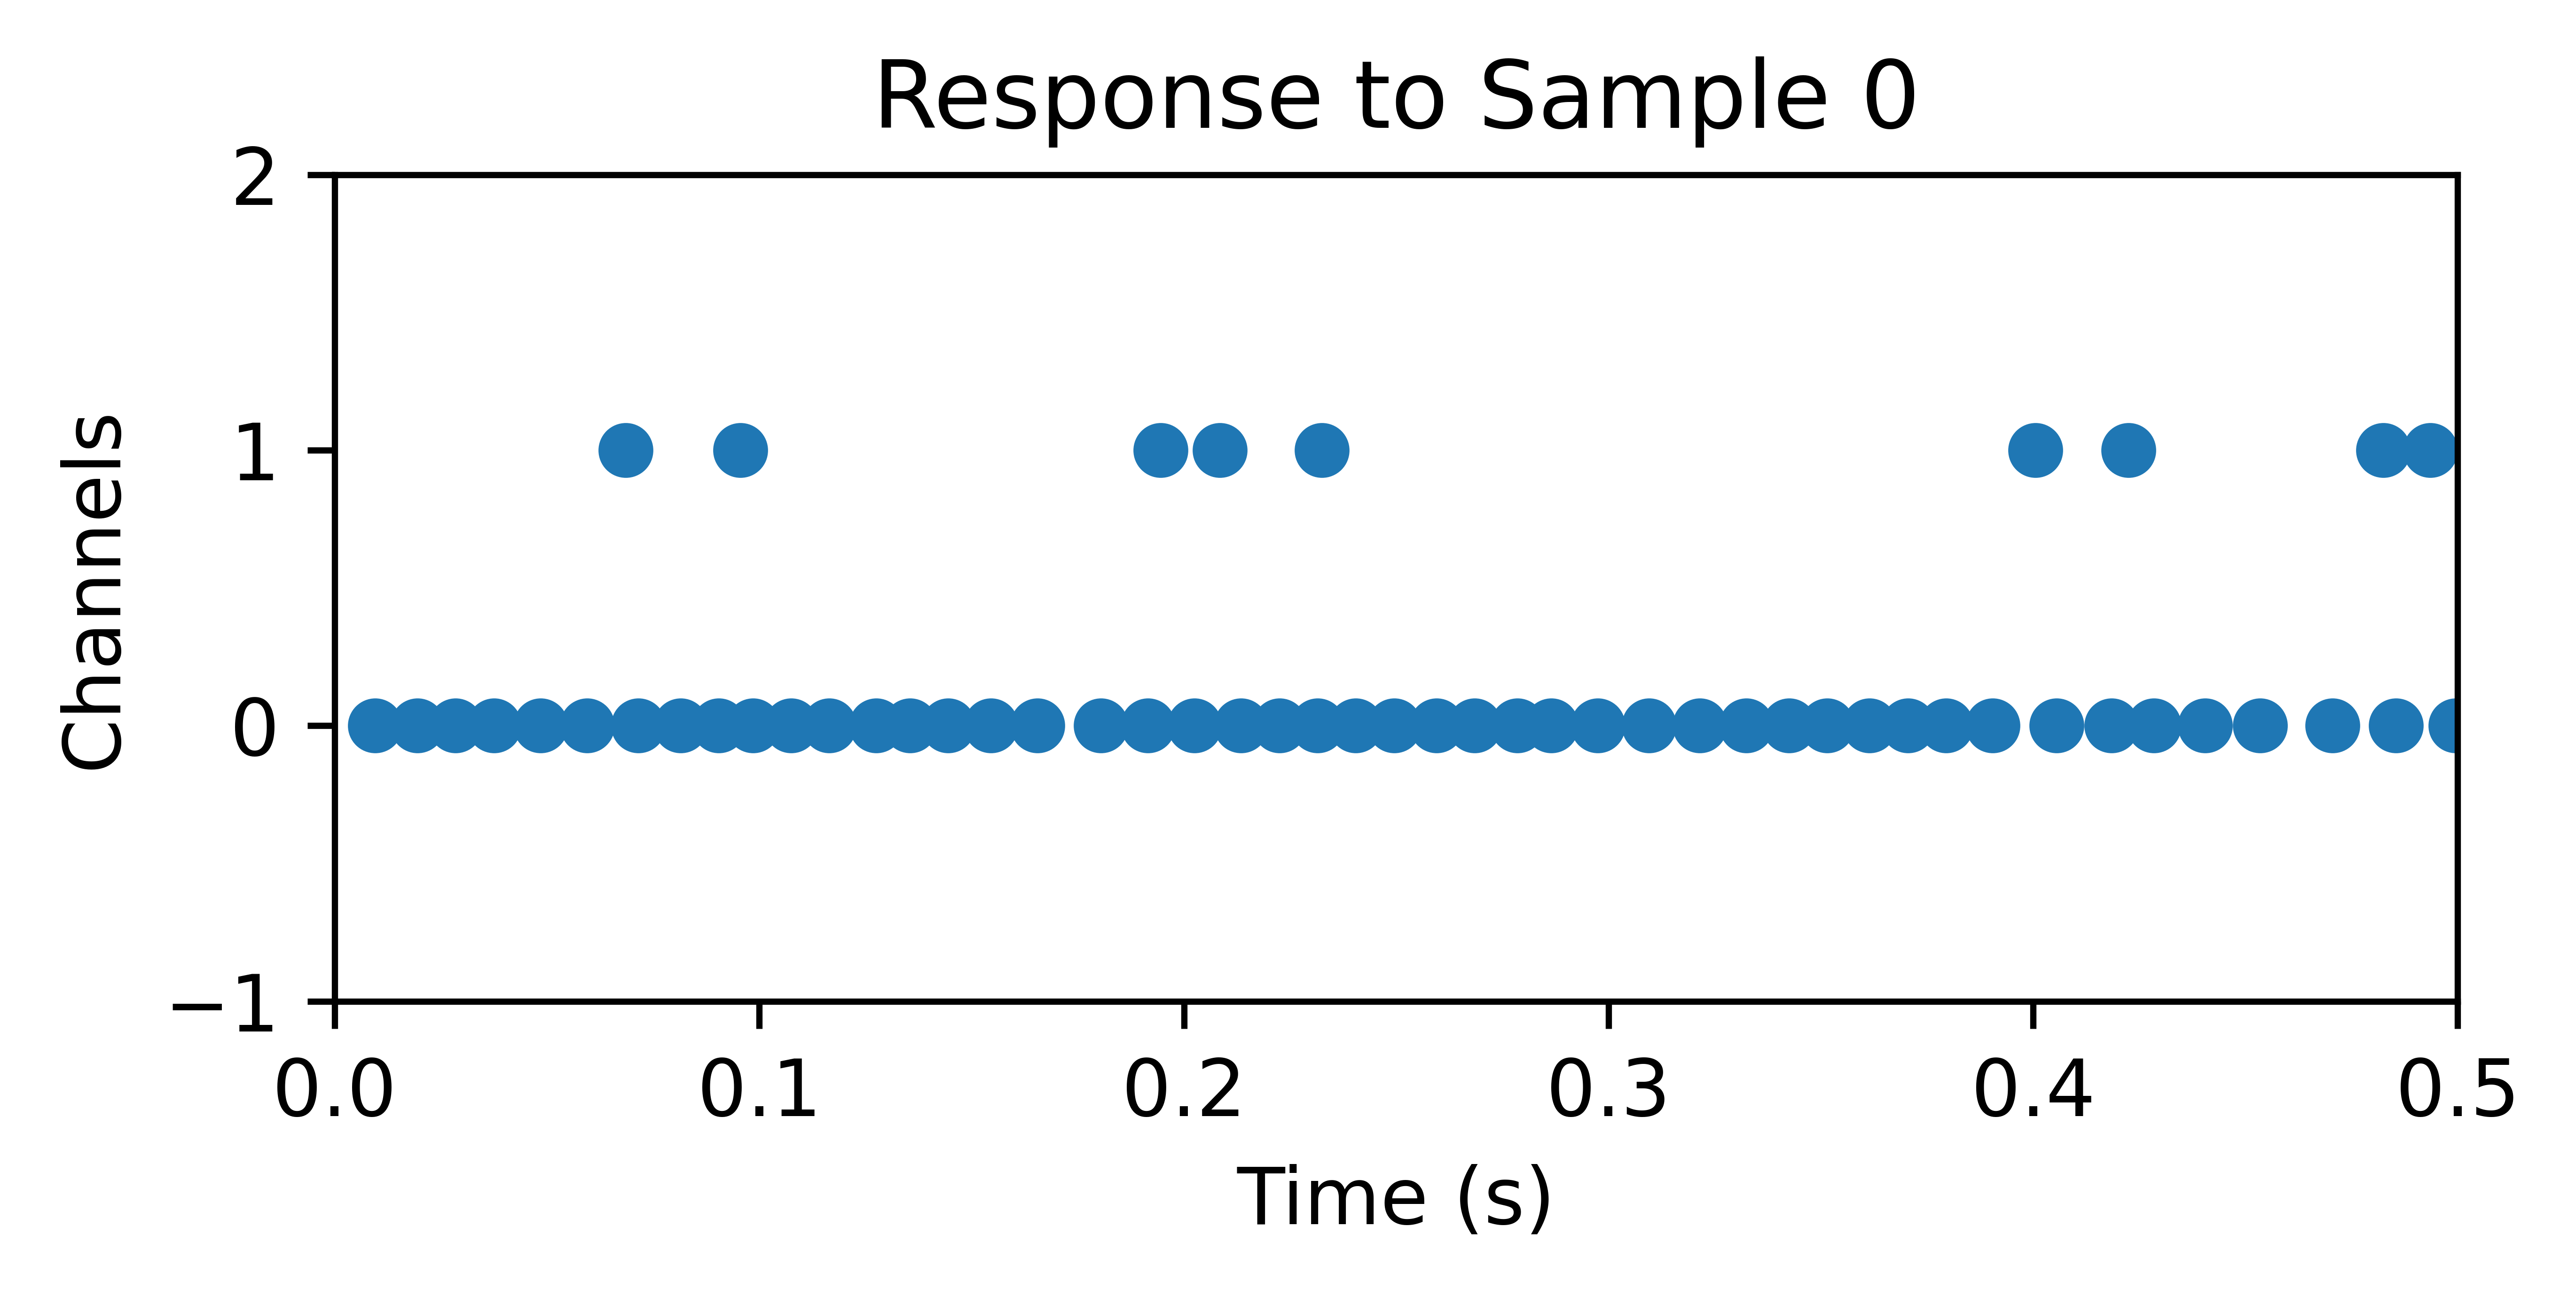

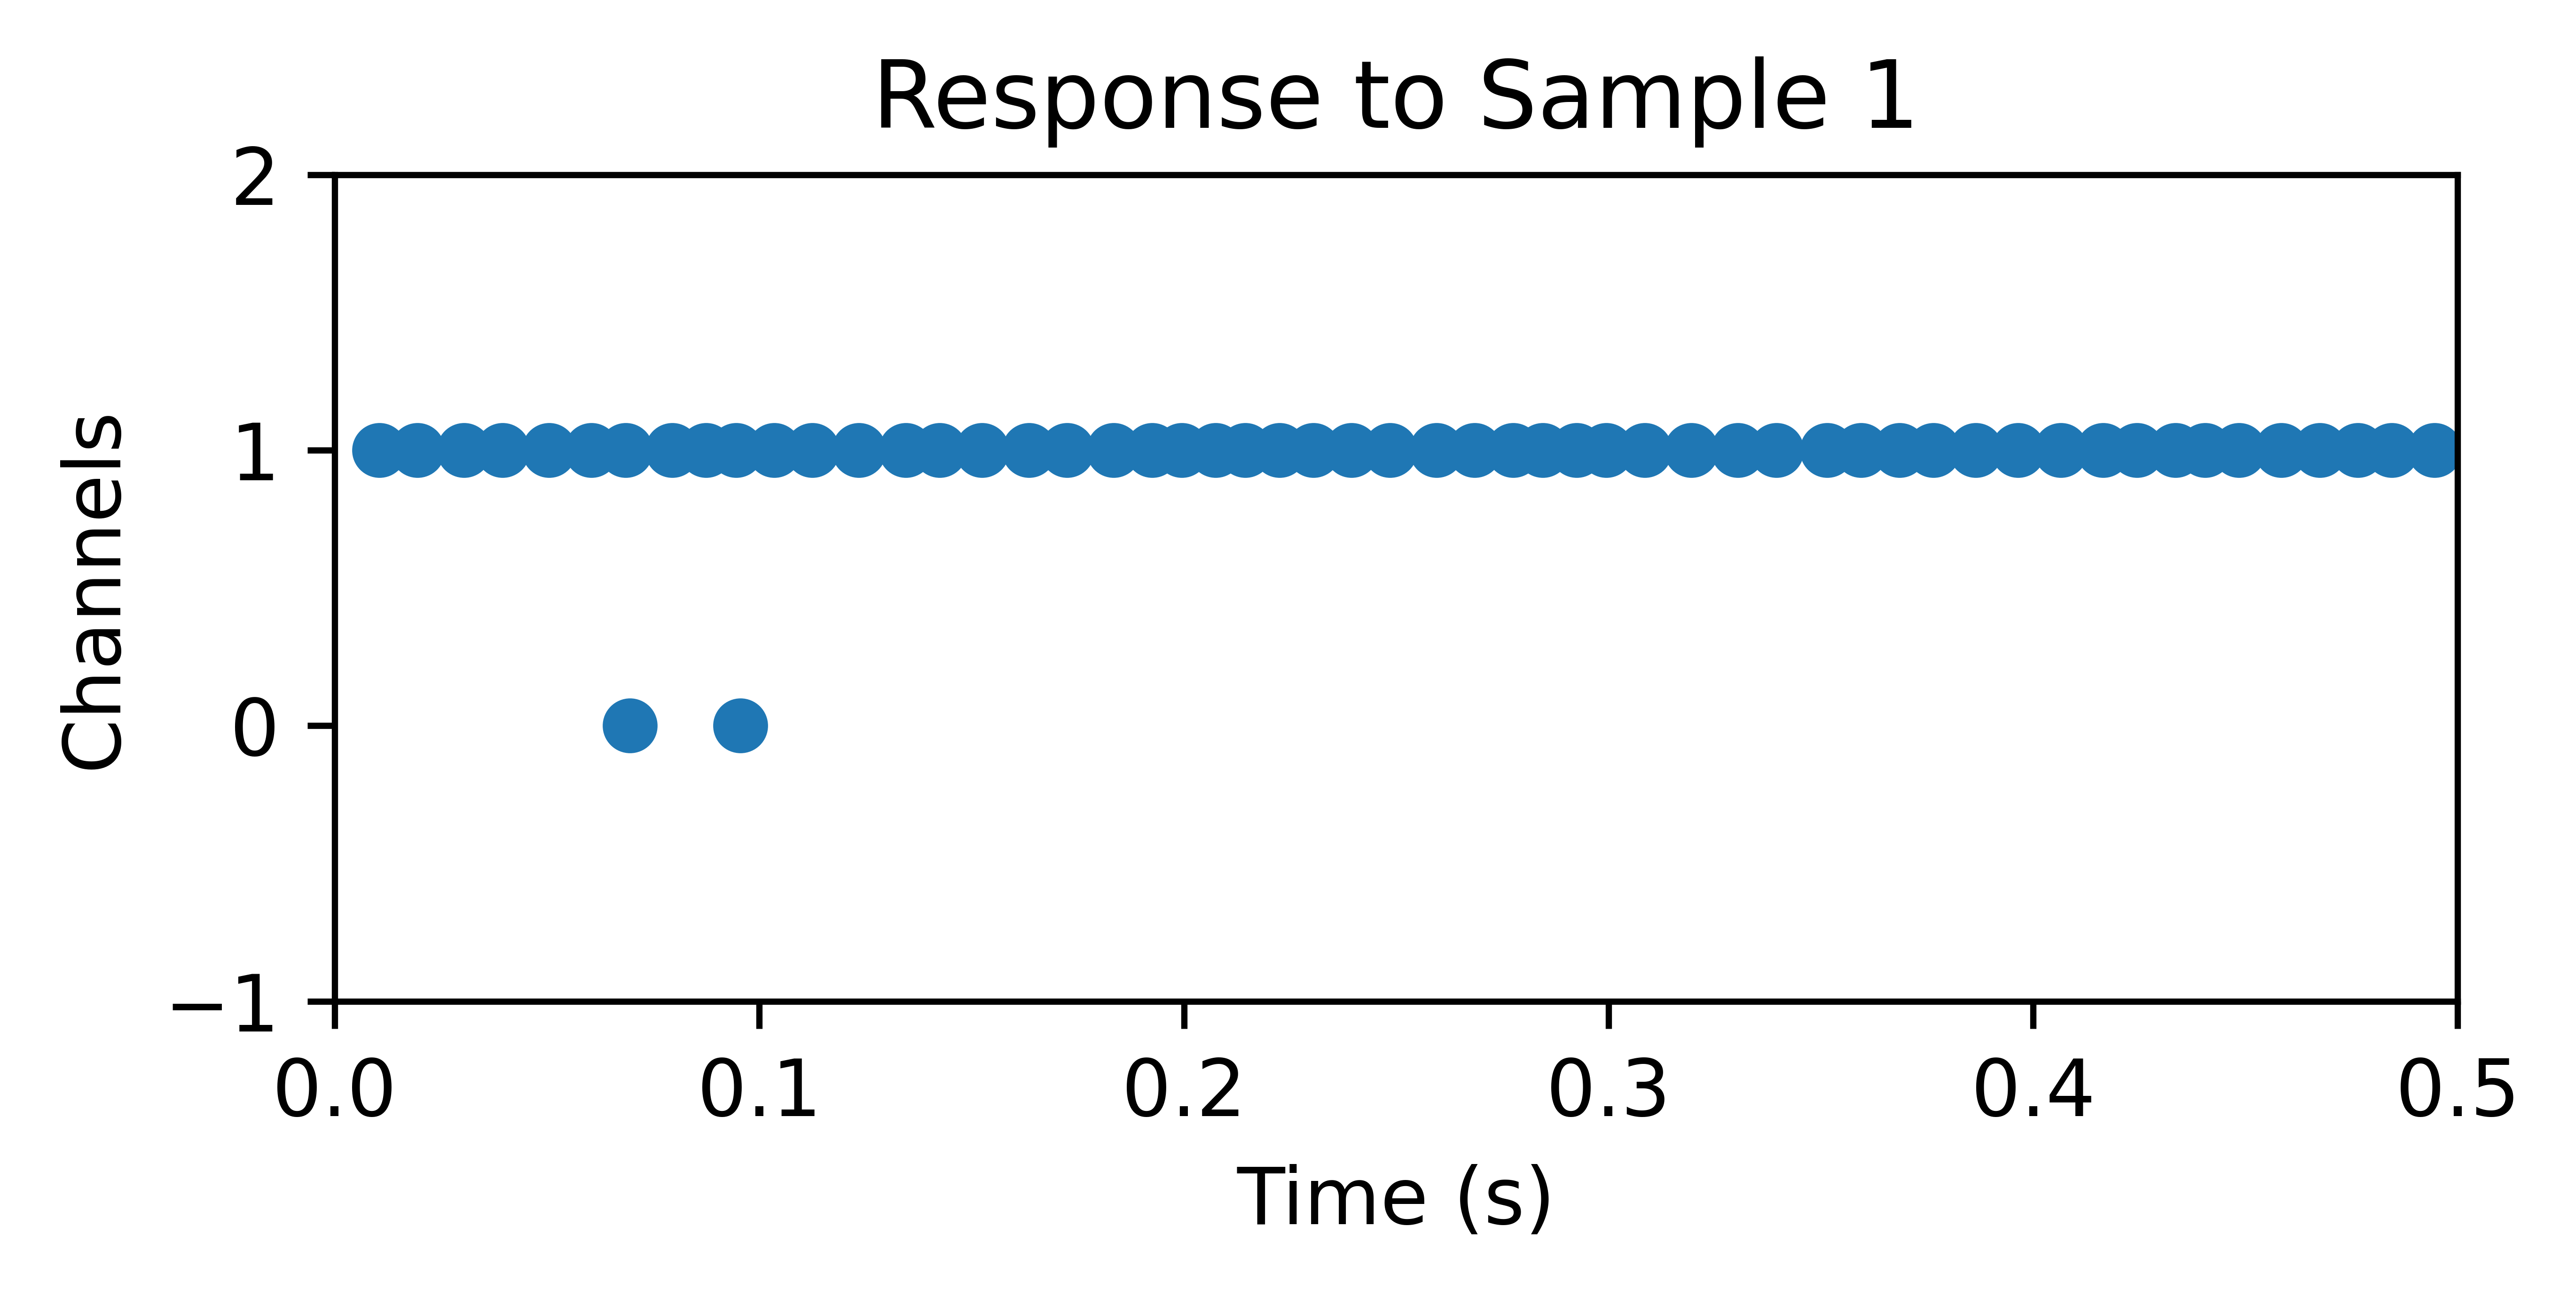

In [17]:
FrozenNoiseDataset.plot_model_response(net_optimized, train_data, dt)

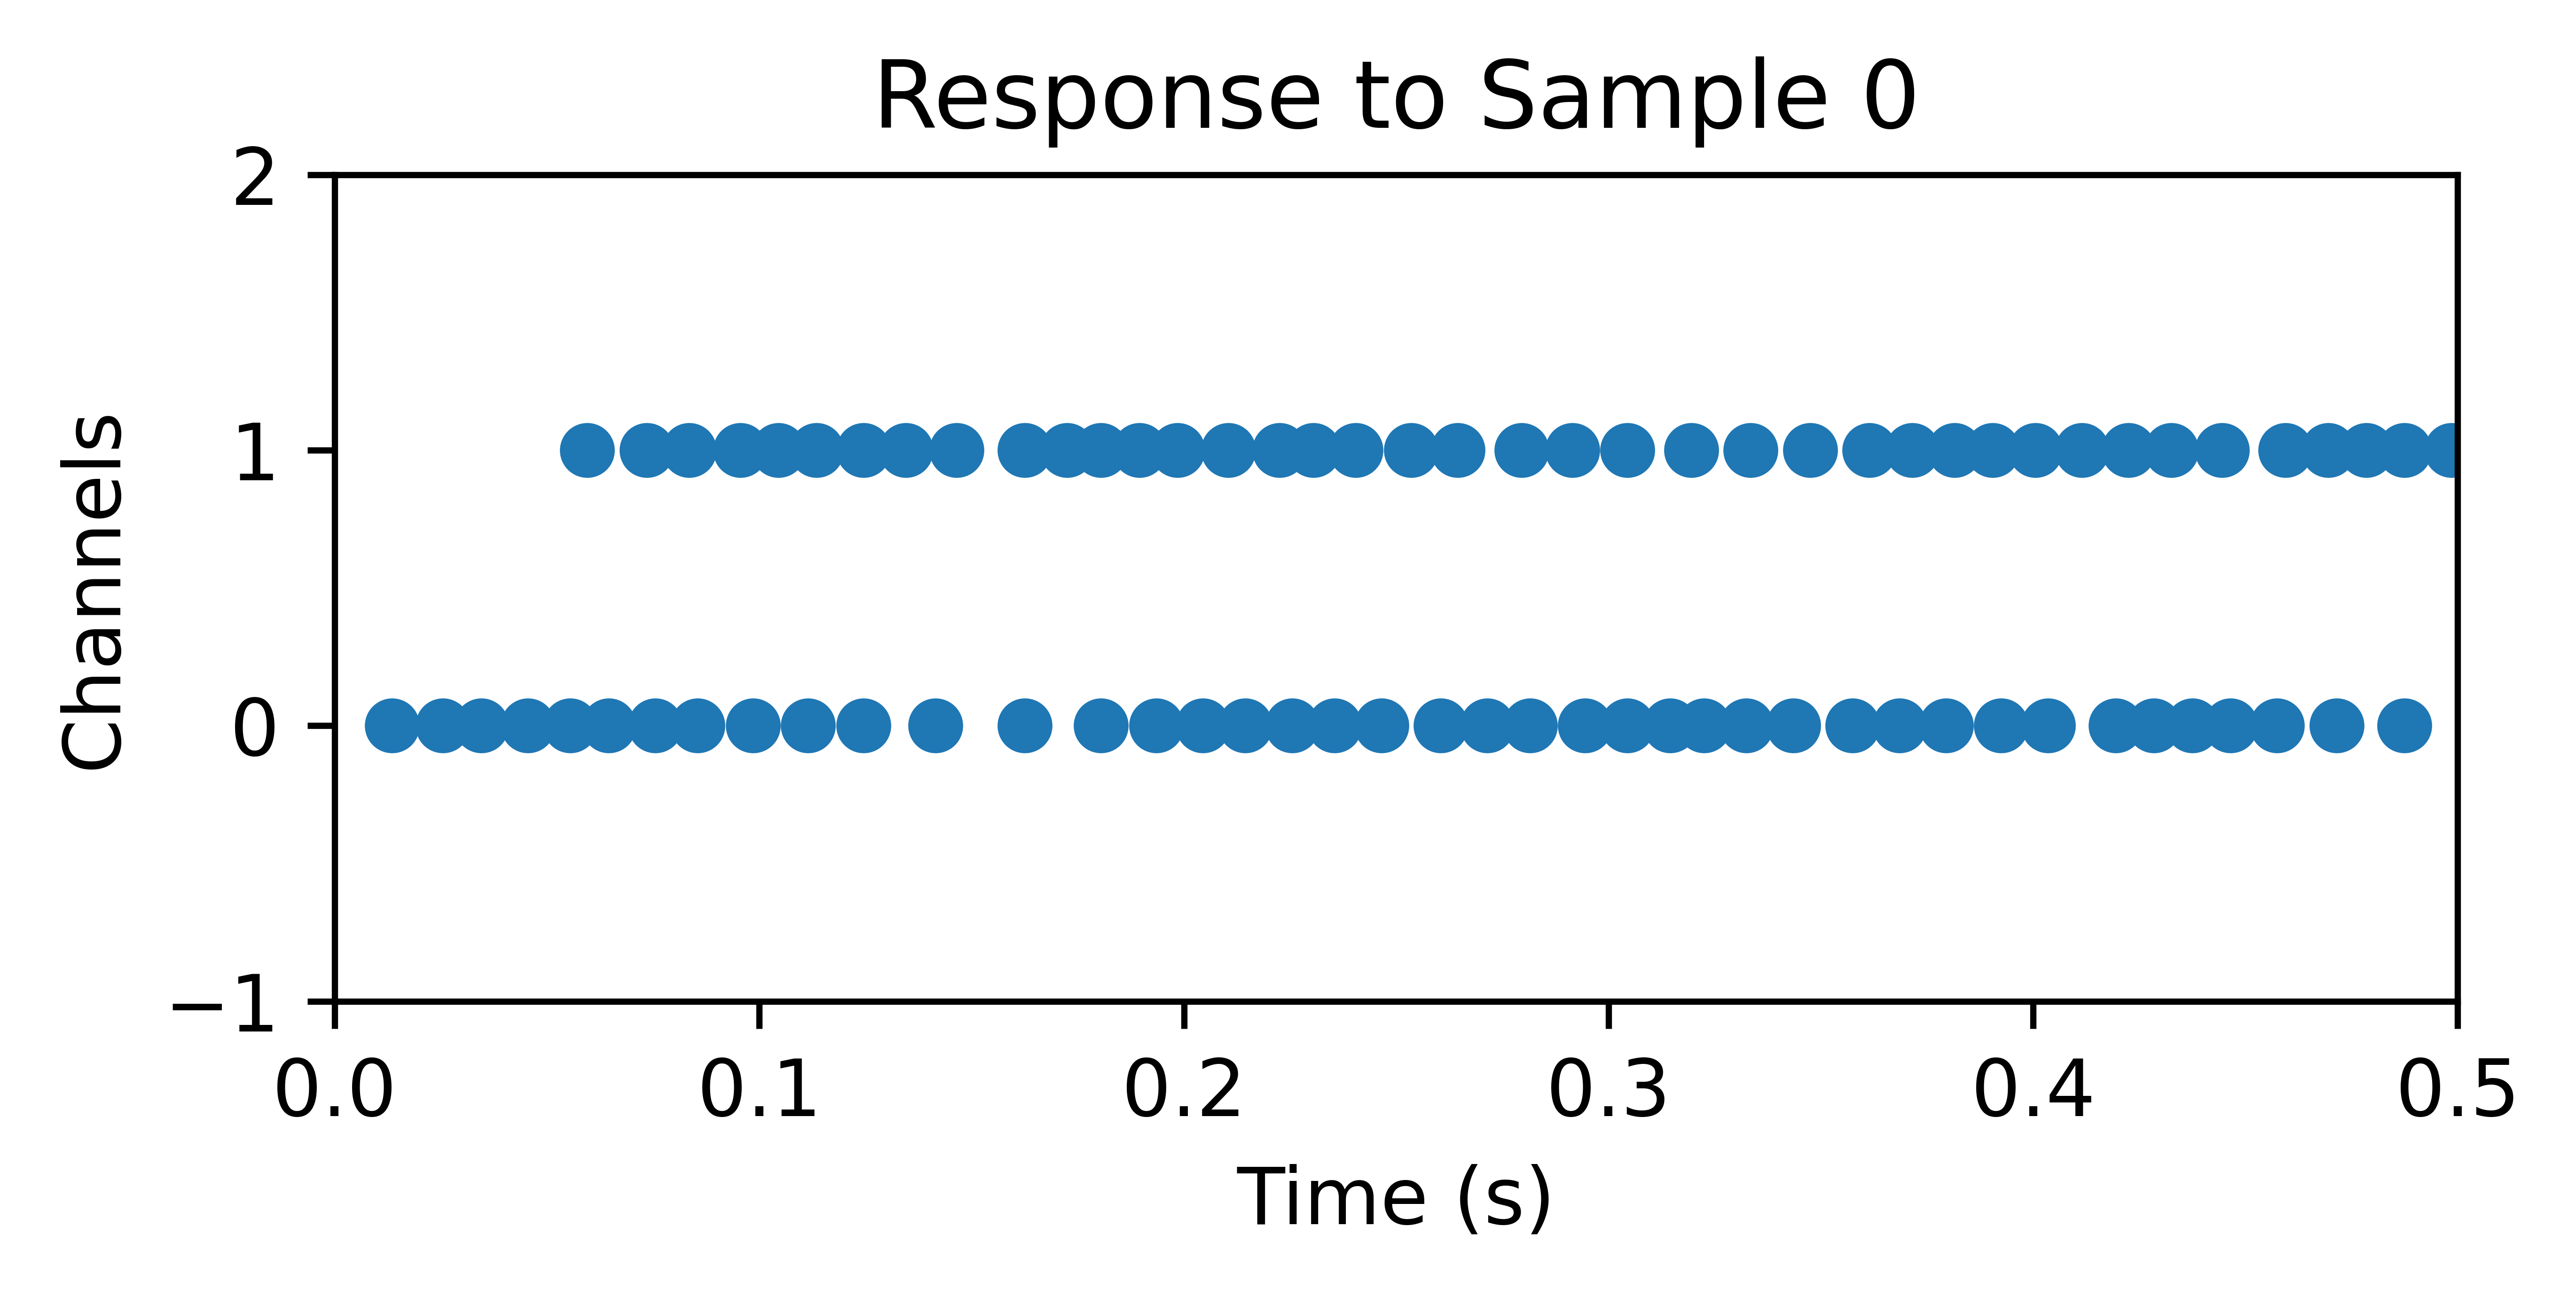

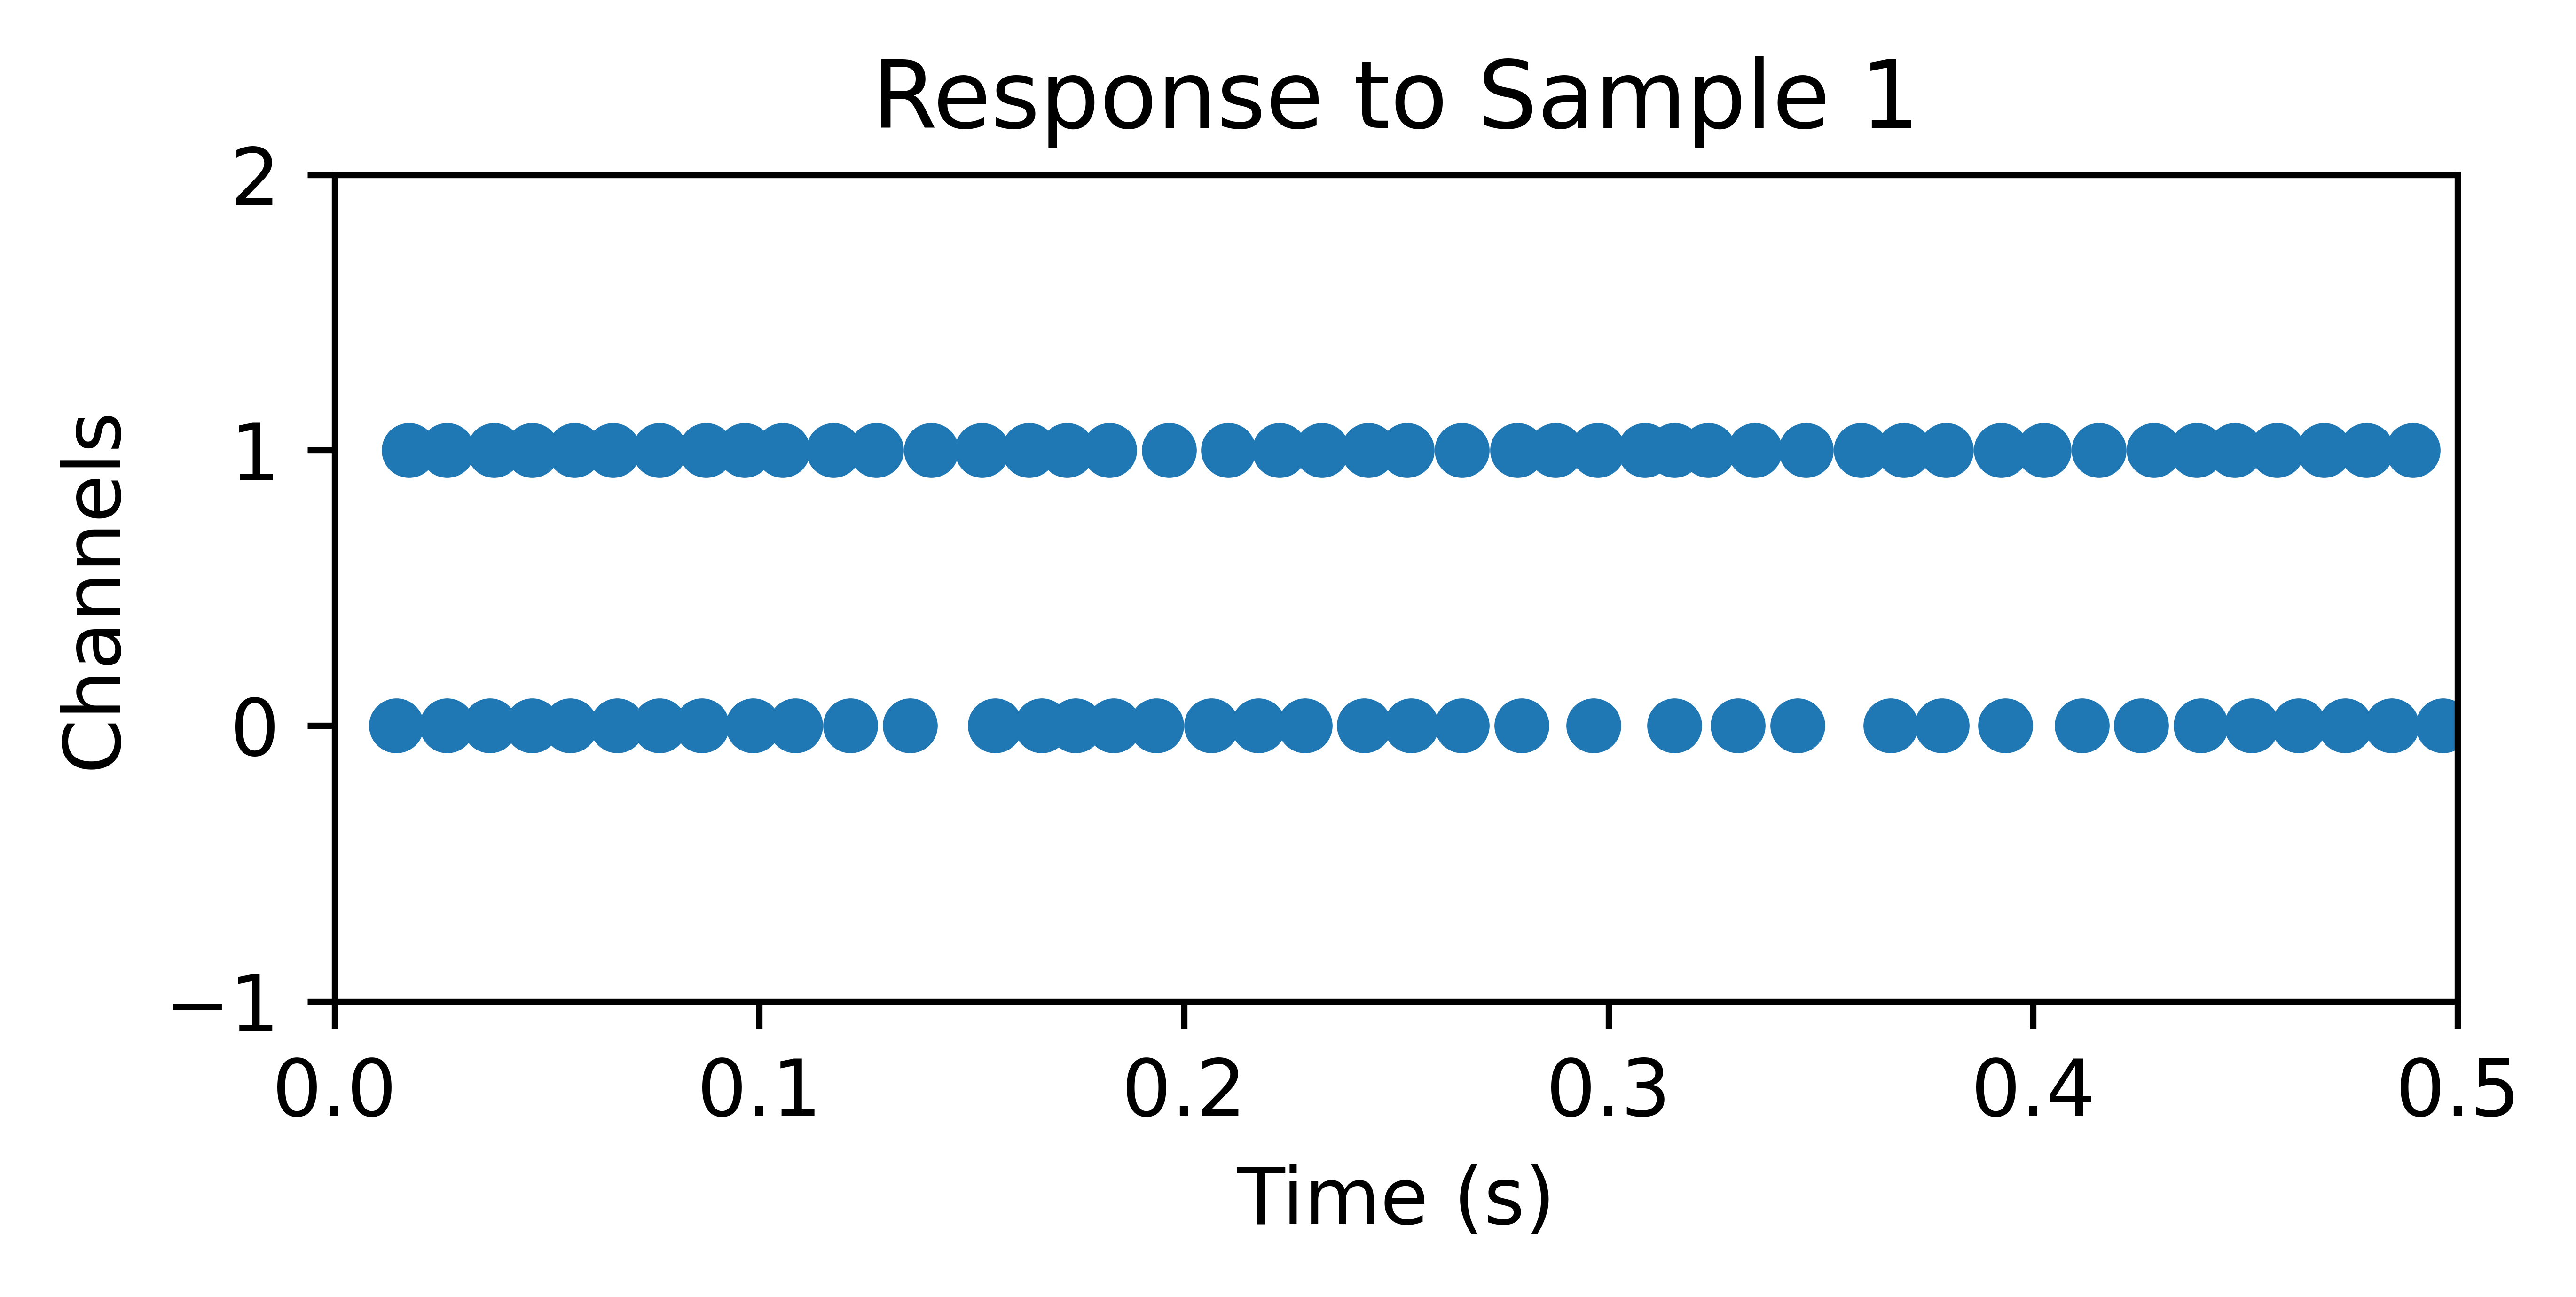

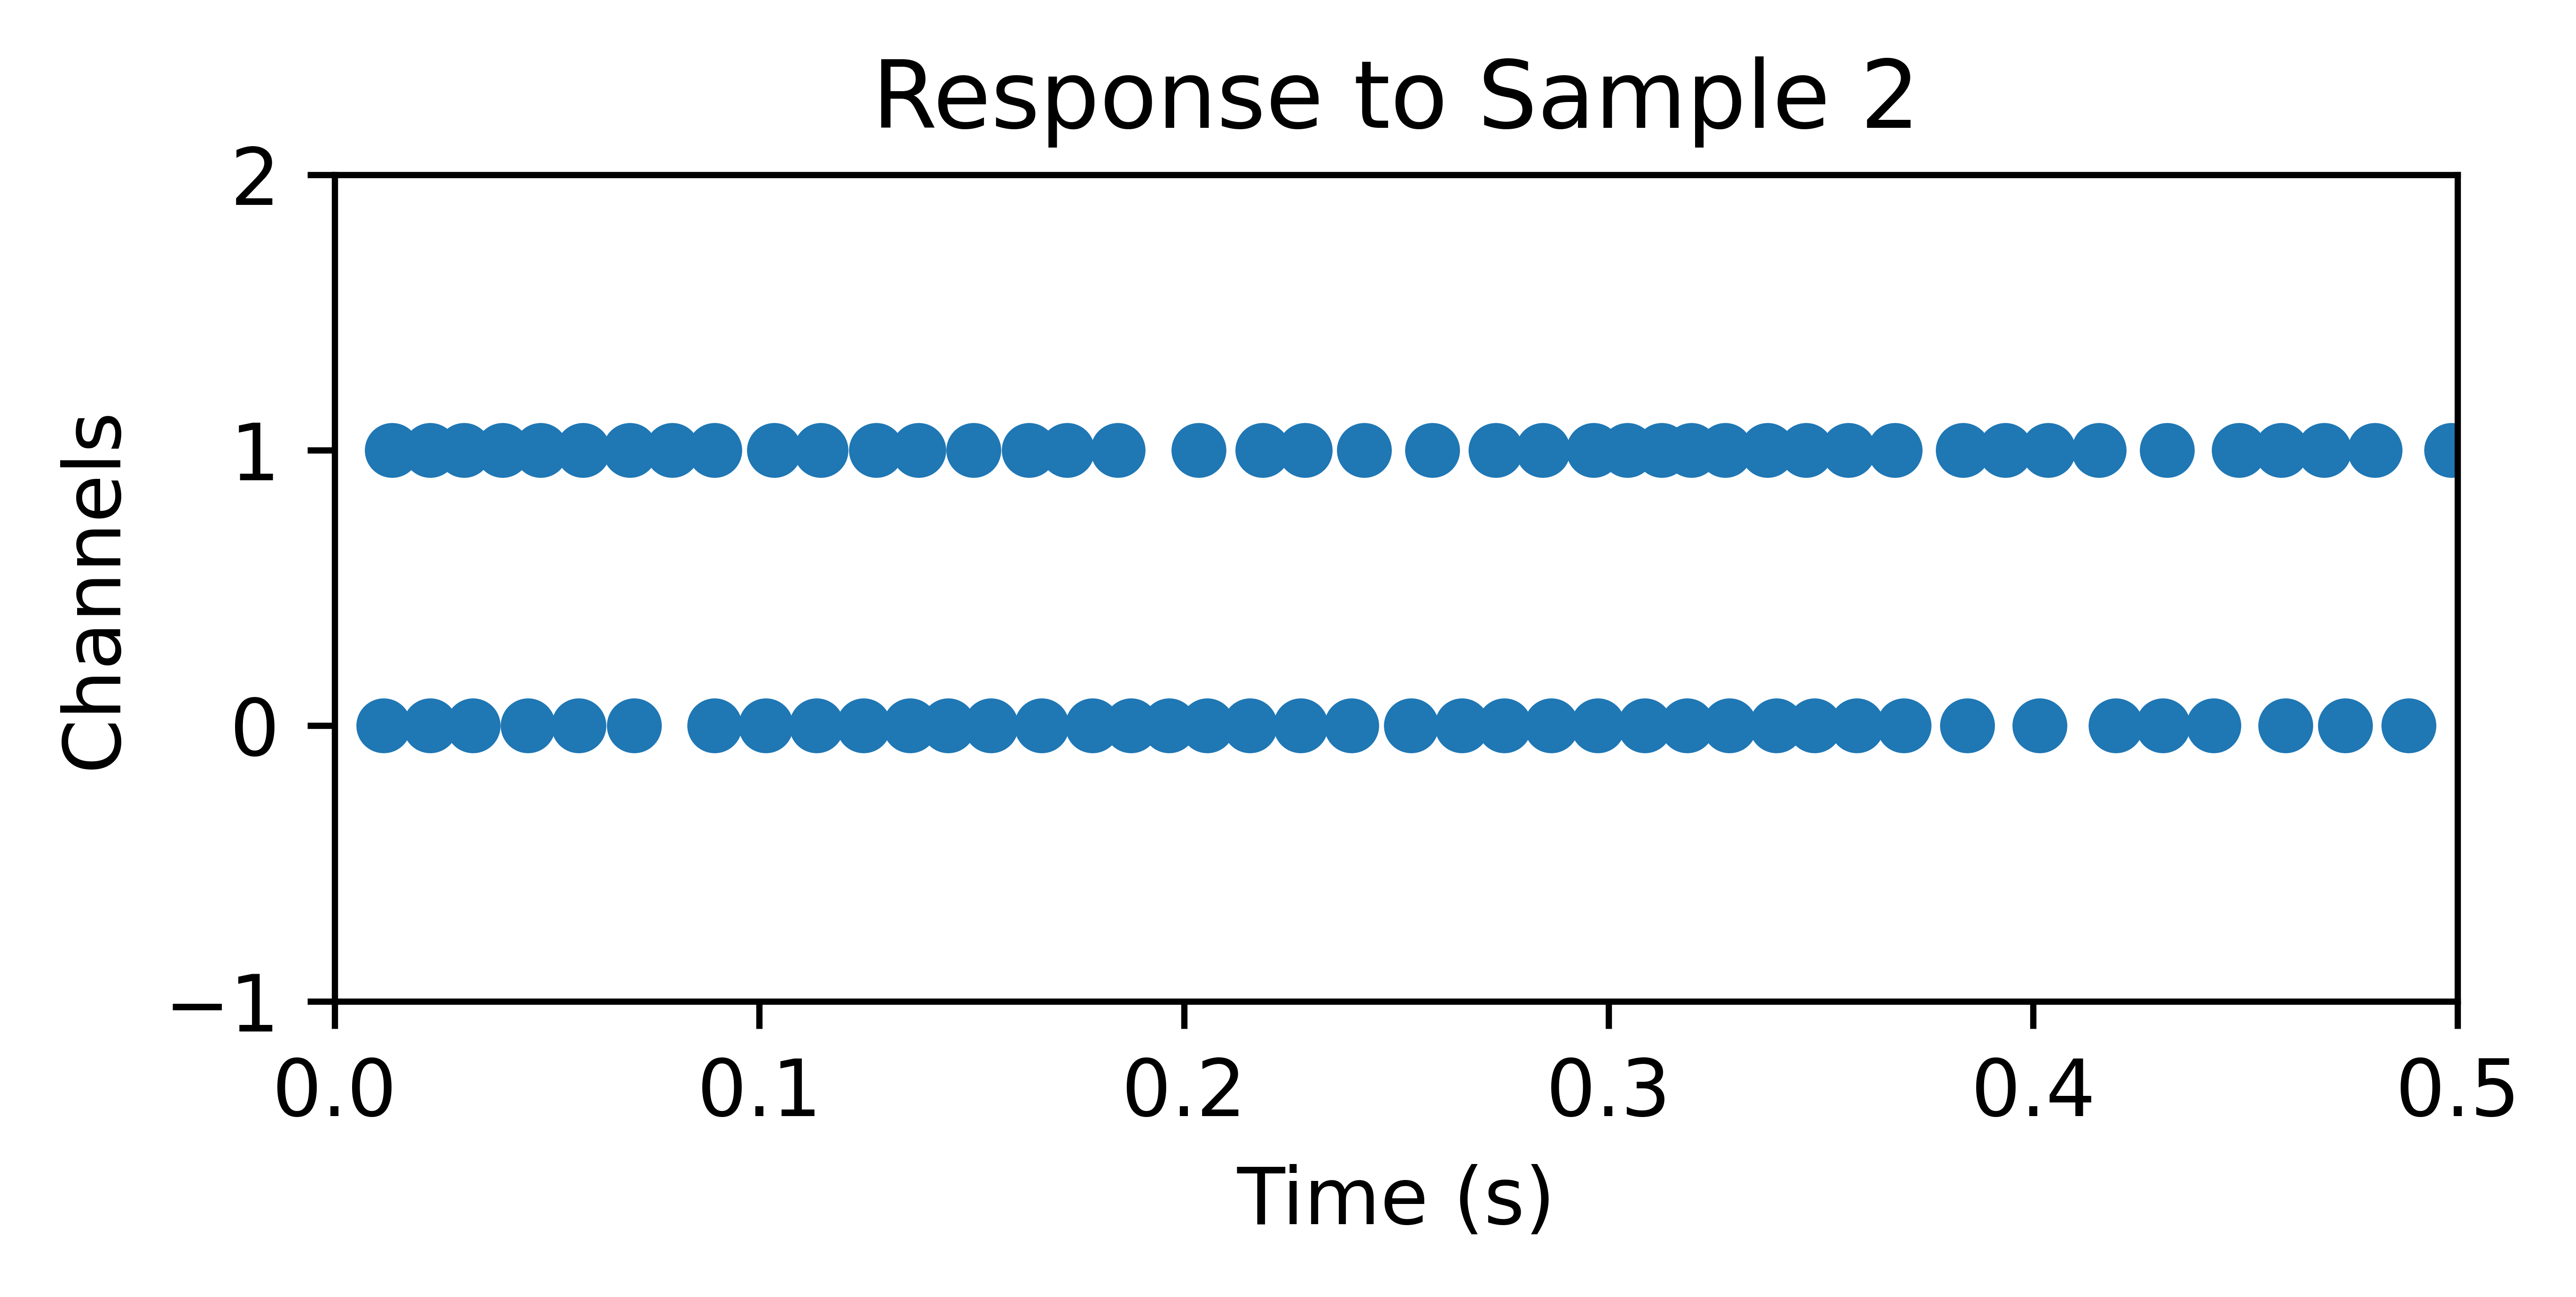

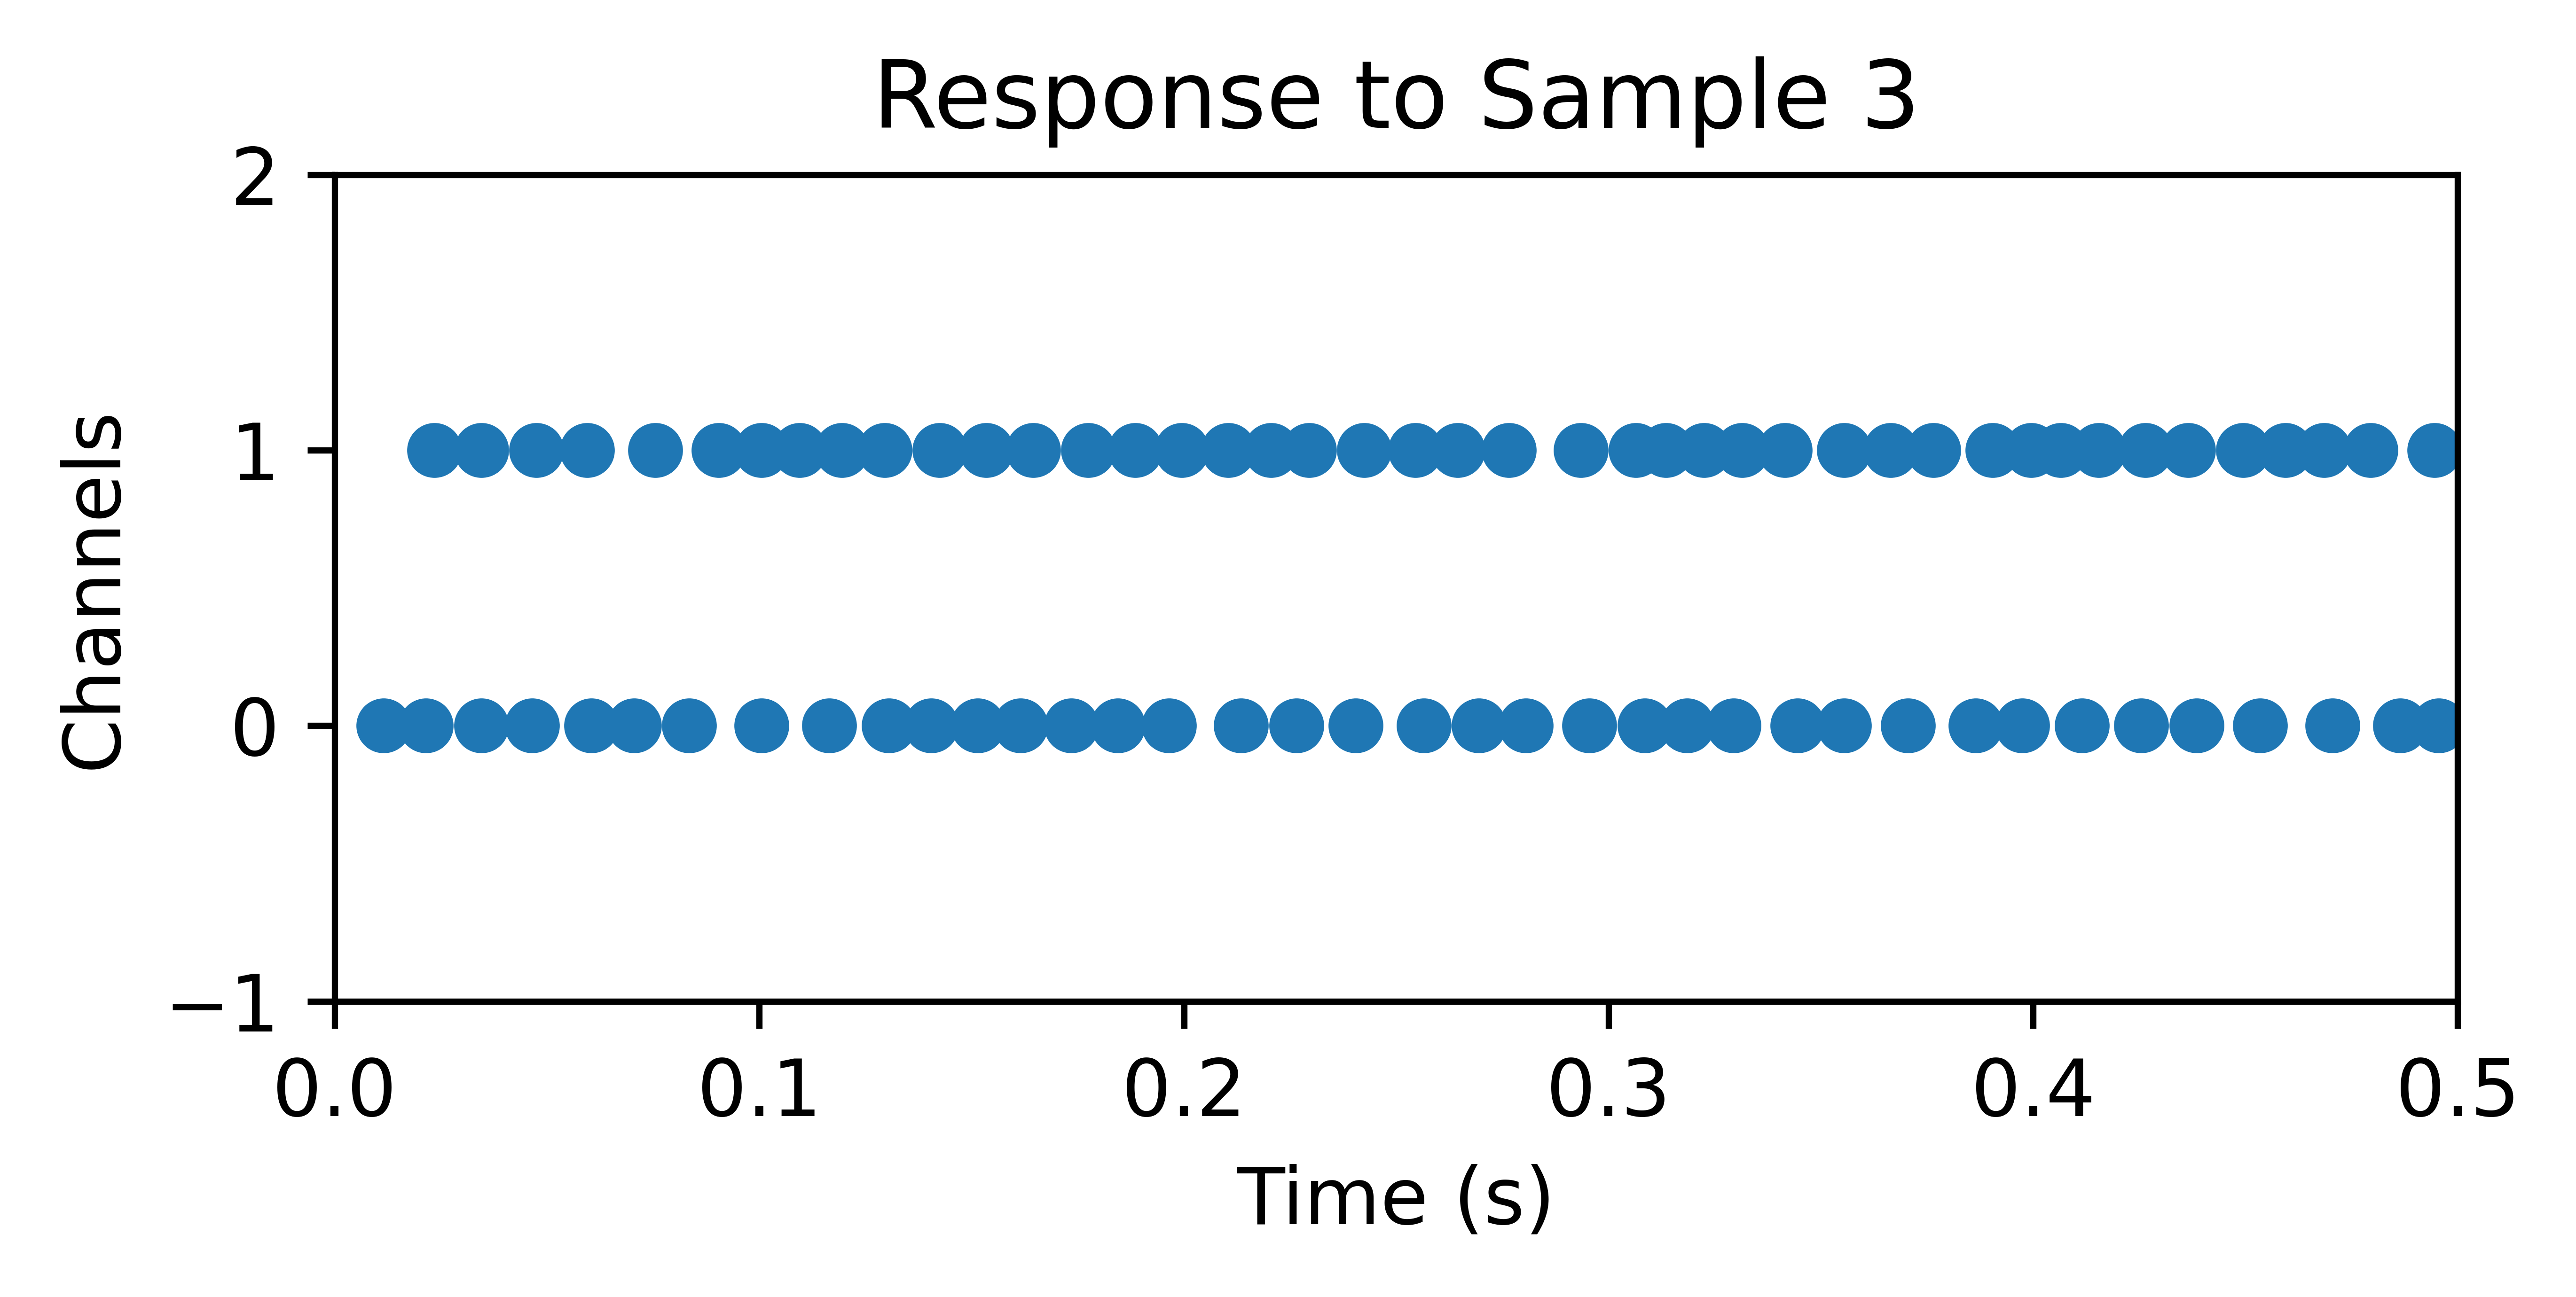

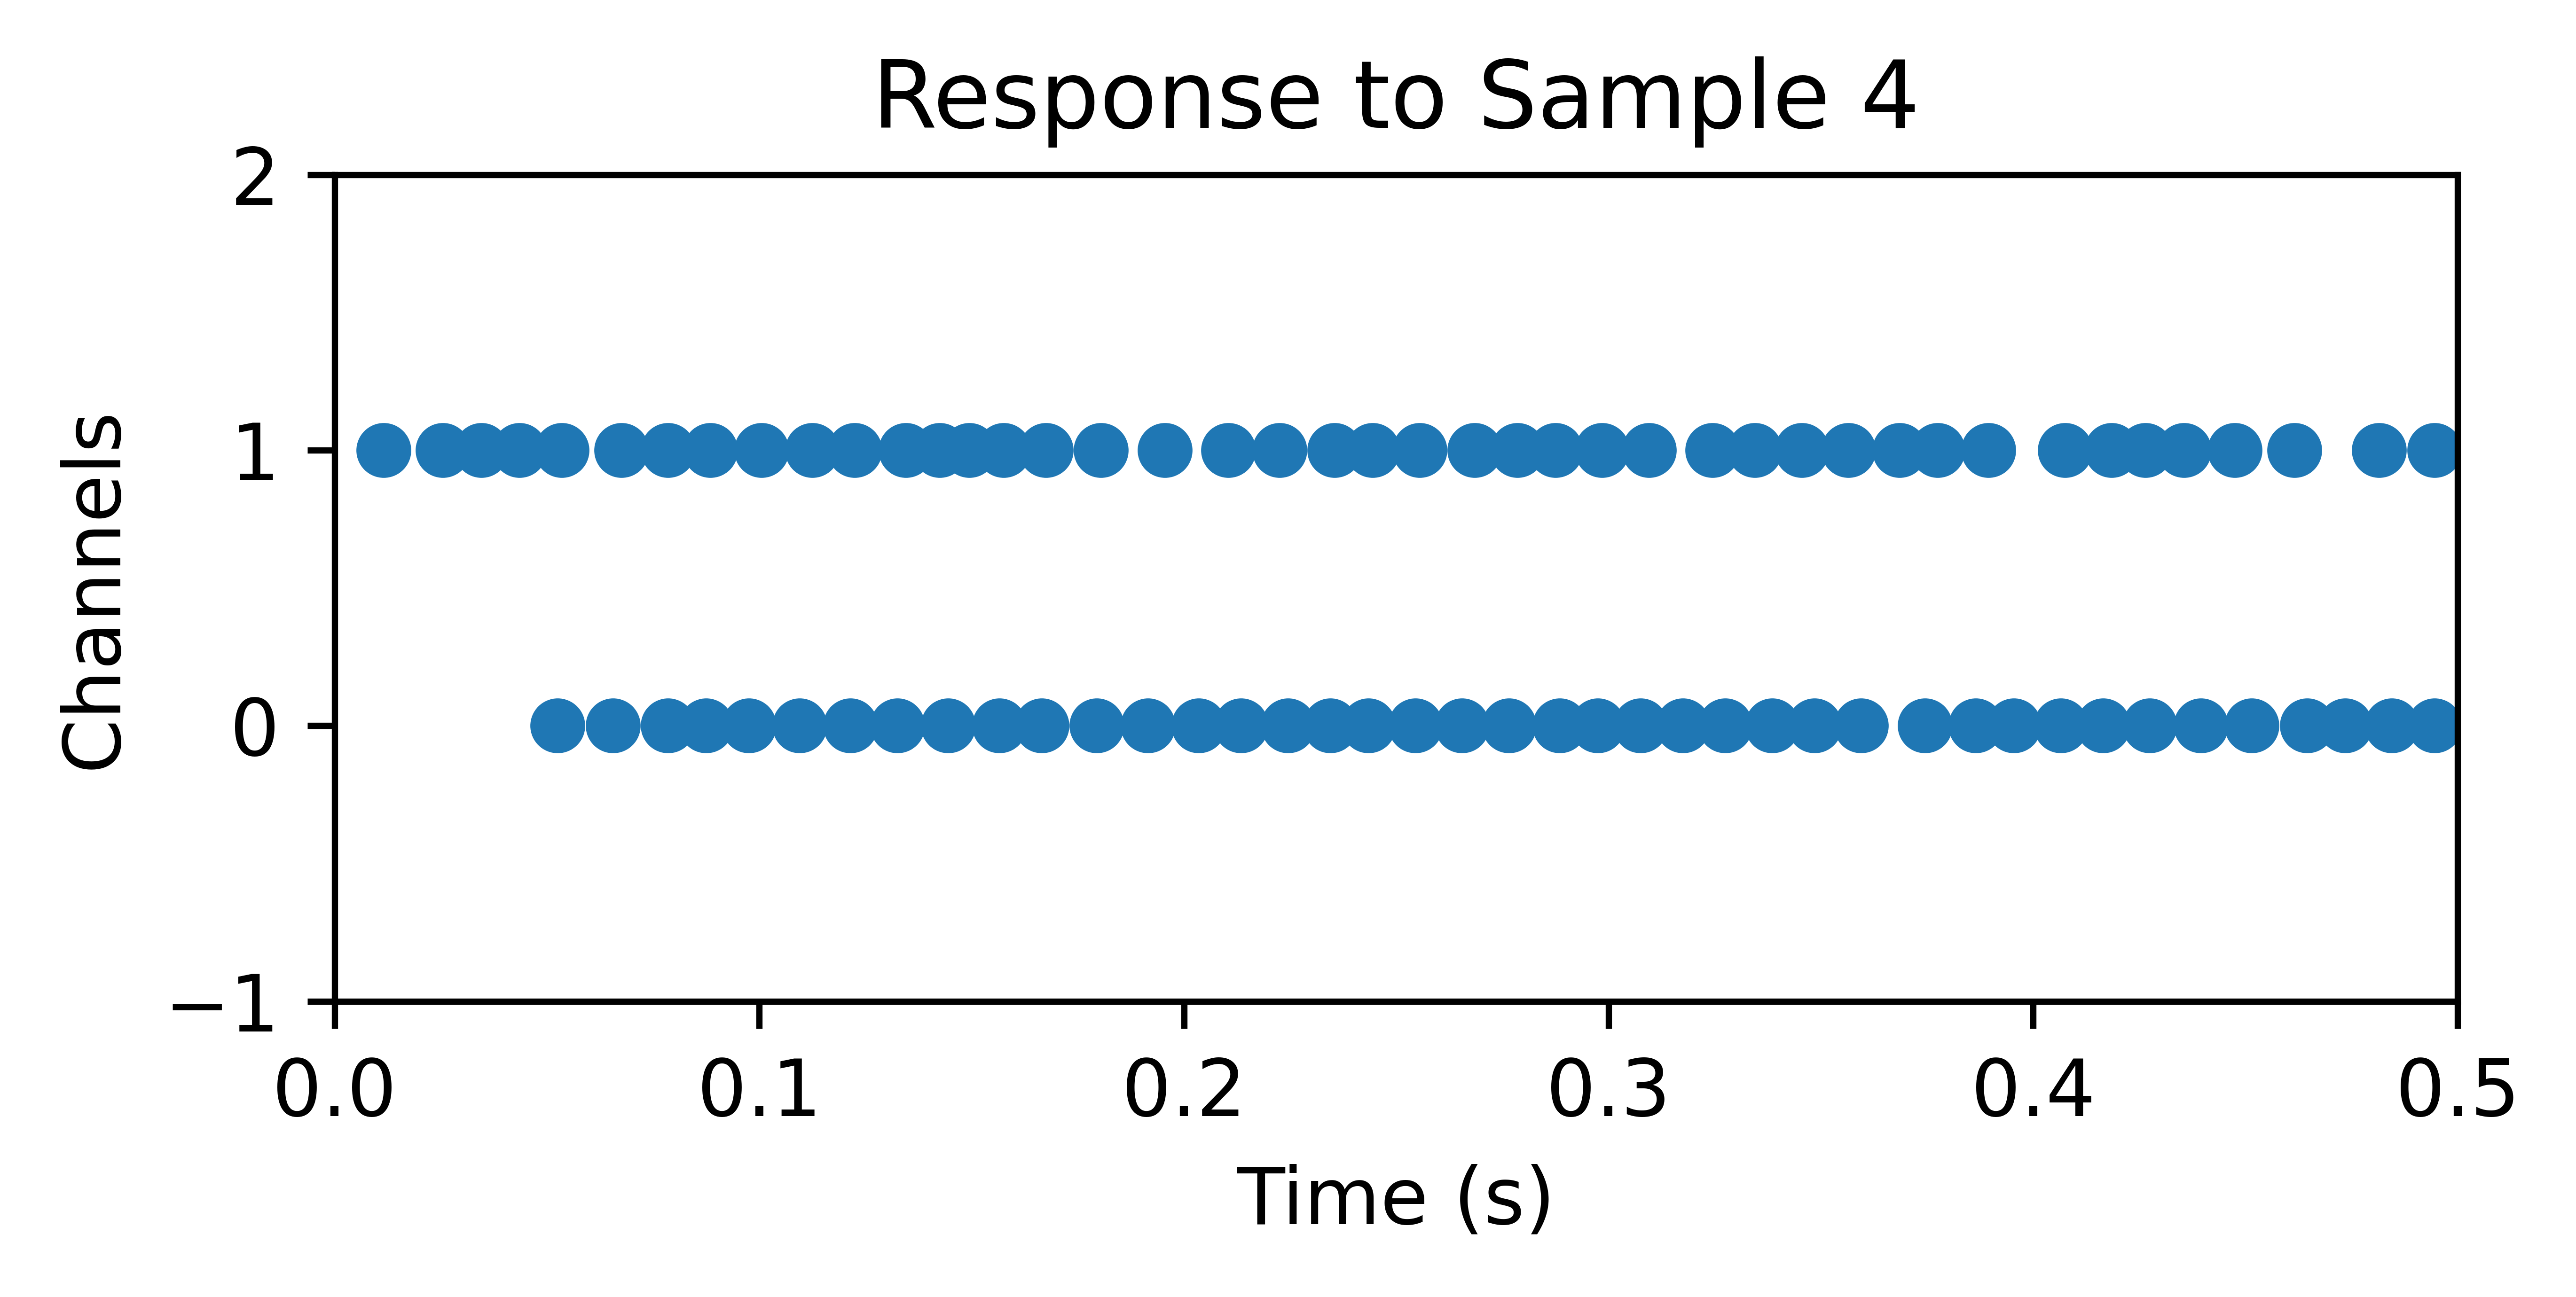

In [18]:
FrozenNoiseDataset.plot_model_response(net_optimized, test_data, dt, range(5))

In [19]:
save_params = True
if save_params:
    p0, p1 = get_params(opt_state).values()

    with open("data/w_in_optimized.npy", "wb") as f:
        np.save(f, p0["weight"])

    with open("data/w_rec_optimized.npy", "wb") as f:
        np.save(f, p1["w_rec"])